In [1]:
from datetime import datetime
import re
import pandas as pd
import numpy as np
from functools import reduce
import glob
import os
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
window_size = 3

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
########################
#  Fonctions utiles  #
########################
def consolidate_date(saison, date_to_consolidate):
    """help to clean date column in L1_joueurs, where many format of date exist at the same time"""
    try : return pd.to_datetime(date_to_consolidate, format='%d.%m.%Y')
    except :
        annee = saison.split('/')
        annee_debut = annee[0]
        annee_fin = annee[1]
        if date_to_consolidate.startswith('Aug') | date_to_consolidate.startswith('Sep') | date_to_consolidate.startswith('Oct') | date_to_consolidate.startswith('Nov') | date_to_consolidate.startswith('Dec'):
            annee_fin = int(annee_fin) - 1
        date_to_consolidate = date_to_consolidate.replace(' ', '')
        date_to_consolidate = date_to_consolidate + '-' + str(annee_fin)
        date_to_consolidate = pd.to_datetime(date_to_consolidate, format='%b%d-%Y')
        return date_to_consolidate

def mean_deroulante(group, column_indices, window_size): #column_metrics
    for col_index in column_indices:
        col_name = group.columns[col_index]
        if group.shape[0] >= 2:
            group.iloc[:, col_index] = group.iloc[:, col_index].rolling(window=window_size, min_periods=0).mean().shift().values
            group.iloc[0, col_index] = group.iloc[1, col_index]
        else : group.iloc[:, col_index] = group.iloc[:, col_index]
    if group.iloc[:, 10].isnull().any() : print(group.iloc[:, :])
    return group

def stats_last_3_and_5_matchs(df):
    df_stats_last_3_and_5_matchs = pd.DataFrame()
    unique_teams_h = df['HomeTeam'].unique()
    unique_teams_a = df['AwayTeam'].unique()
    all_unique_teams = np.concatenate((unique_teams_h, unique_teams_a))
    all_unique_teams = np.unique(all_unique_teams)
    for team in all_unique_teams:
      team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
      team_matches = team_matches.sort_values(by='Date', ascending=True).reset_index(drop=True)
      team_matches["team_series"] = team
      team_matches["victoire"] = team_matches.apply(lambda row: 1 if (row['HomeTeam']==team and row['FTR'] == 'H')|(row['AwayTeam']==team and row['FTR'] == 'A') else 0, axis=1)
      team_matches["defaite"] = team_matches.apply(lambda row: 1 if (row['HomeTeam']==team and row['FTR'] == 'A')|(row['AwayTeam']==team and row['FTR'] == 'H') else 0, axis=1)
      team_matches["sum_win_last_5"] = team_matches["victoire"].shift(1).rolling(window=5, min_periods=1).sum()
      team_matches["sum_lose_last_5"] = team_matches["defaite"].shift(1).rolling(window=5, min_periods=1).sum()
      team_matches["sum_win_last_3"] = team_matches["victoire"].shift(1).rolling(window=3, min_periods=1).sum()
      team_matches["sum_lose_last_3"] = team_matches["defaite"].shift(1).rolling(window=3, min_periods=1).sum()
      team_matches.loc[0, "sum_win_last_5"] = team_matches.loc[0, "victoire"]
      team_matches.loc[0, "sum_lose_last_5"] = team_matches.loc[0, "defaite"]
      team_matches.loc[0, "sum_win_last_3"] = team_matches.loc[0, "victoire"]
      team_matches.loc[0, "sum_lose_last_3"] = team_matches.loc[0, "defaite"]
      df_stats_last_3_and_5_matchs = pd.concat([df_stats_last_3_and_5_matchs, team_matches], ignore_index=True)
    return df_stats_last_3_and_5_matchs

def get_saison(date):
    annee_debut = date.year if date.month >= 8 else date.year - 1
    annee_fin = annee_debut + 1
    return f"{annee_debut}-{annee_fin}"

In [3]:
########################
# Travail sur L1_all_season.csv #
########################

In [4]:
path = "/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_all_season_raw_files/"
dfs = []
common_columns = None
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        df = pd.read_csv(filepath)
        if common_columns is None:
            common_columns = set(df.columns)
        else:
            common_columns.intersection_update(df.columns)
        dfs.append(df)
dfs_common_columns = [df[list(common_columns)] for df in dfs]
L1_main_stats_cotes = pd.concat(dfs_common_columns, ignore_index=True)

In [5]:
########################
# On clean une première fois #
########################

In [6]:
L1_main_stats_cotes['Date'] = pd.to_datetime(L1_main_stats_cotes['Date'], format='mixed', dayfirst=True)
L1_main_stats_cotes['Season'] = L1_main_stats_cotes['Date'].apply(get_saison)
L1_main_stats_cotes = L1_main_stats_cotes[L1_main_stats_cotes['Season']!='nan-nan']

In [7]:
L1_main_stats_cotes = L1_main_stats_cotes.dropna(subset=['HomeTeam'])
L1_main_stats_cotes = L1_main_stats_cotes[(L1_main_stats_cotes["HomeTeam"]!="Evian Thonon Gaillard")&(L1_main_stats_cotes["AwayTeam"]!="Evian Thonon Gaillard")]
L1_main_stats_cotes['bkm_prediction'] = L1_main_stats_cotes[['B365H', 'B365D', 'B365A']].apply(lambda x: np.argmin(x), axis=1)
L1_main_stats_cotes['bkm_prediction'].replace({0:1, 1:0, 2:2},inplace=True)  # parce que {'A': 2, 'D': 0, 'H': 1} pour le reste du code
L1_main_stats_cotes = L1_main_stats_cotes.drop(['IWA','IWD','IWH'], axis=1)

In [8]:
########################
# On réorganise les colonnes et on enleve les colonnes qui ont trop de valeurs NULL.
########################

In [9]:
seuil = 0.05
col_lot_of_null = (L1_main_stats_cotes.isnull().sum() / len(L1_main_stats_cotes))
col_lot_of_null = col_lot_of_null[col_lot_of_null > seuil].index.tolist()

nouvel_ordre_colonnes = ["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season","bkm_prediction"
                         "FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR","B365H","B365D","B365A","BWH","BWD","BWA","WHH","WHD","WHA","VCH","VCD","VCA"
                        ]

nouvel_ordre_colonnes = ["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season",
                         "FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR","B365H","B365D","B365A","BWH","BWD","BWA","PSH","PSD","PSA","WHH","WHD","WHA","VCH","VCD","VCA","PSCH","PSCD","PSCA","B365C>2.5","B365C<2.5","PC>2.5","PC<2.5","MaxC>2.5","MaxC<2.5","AvgC>2.5","AvgC<2.5","AHCh","B365CAHH","B365CAHA","PCAHH","PCAHA","MaxCAHH","MaxCAHA","AvgCAHH","AvgCAHA"
                        ]


nouvel_ordre_colonnes = [col for col in nouvel_ordre_colonnes if col not in col_lot_of_null]

nouvel_ordre_H = ["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season",
                         "FTHG","HTHG","HS","HST","HF","HC","HY","HR"
                 ]
nouvel_ordre_H = [col for col in nouvel_ordre_H if col not in col_lot_of_null]

nouvel_ordre_A = ["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season",
                         "FTAG","HTAG","AS","AST","AF","AC","AY","AR"
                 ]
nouvel_ordre_A = [col for col in nouvel_ordre_A if col not in col_lot_of_null]

nouvel_ordre_Cote = ["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season",
                     "bkm_prediction","B365H","B365D","B365A","BWH","BWD","BWA","WHH","WHD","WHA","VCH","VCD","VCA"
                    ]
nouvel_ordre_Cote = [col for col in nouvel_ordre_Cote if col not in col_lot_of_null]

In [10]:
########################
# On fait un DF avec moyenne roulante sur les stats des matchs. Pas sur les cotes des bookmakers, car on a la data avant le match #
# On aura un DF avec moyenne (pour le modèle) et un DF avec les vrai stats (pour les annalyses sur les features)
########################

In [11]:
L1_main_stats_H = L1_main_stats_cotes[nouvel_ordre_H]
L1_main_stats_A = L1_main_stats_cotes[nouvel_ordre_A]
L1_main_stats_Cote = L1_main_stats_cotes[nouvel_ordre_Cote]

L1_main_stats_H = L1_main_stats_H.sort_values(by=['HomeTeam', 'Date']).reset_index(drop=True)
L1_main_stats_A = L1_main_stats_A.sort_values(by=['AwayTeam', 'Date']).reset_index(drop=True)

column_indices = list(range(7, len(L1_main_stats_H.columns)))
L1_main_stats_H_roulante = L1_main_stats_H.sort_values(by=['Div','HomeTeam','Date']).reset_index(drop=True).groupby(['Div','HomeTeam'],group_keys=False).apply(lambda x: mean_deroulante(x, column_indices, window_size))

column_indices = list(range(7, len(L1_main_stats_A.columns)))
L1_main_stats_A_roulante = L1_main_stats_A.sort_values(by=['Div','HomeTeam','Date']).reset_index(drop=True).groupby(['Div','AwayTeam'],group_keys=False).apply(lambda x: mean_deroulante(x, column_indices, window_size))

L1_main_stats_cotes_roulante = pd.merge(L1_main_stats_H_roulante, L1_main_stats_A_roulante, how="inner", left_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"], right_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"])
L1_main_stats_cotes_roulante = pd.merge(L1_main_stats_cotes_roulante, L1_main_stats_Cote, how="inner", left_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"], right_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"])
L1_main_stats_cotes_roulante = L1_main_stats_cotes_roulante.dropna(subset=['FTHG','FTAG'])

L1_main_stats_cotes = pd.merge(L1_main_stats_H, L1_main_stats_A, how="inner", left_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"], right_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"])
L1_main_stats_cotes = pd.merge(L1_main_stats_cotes, L1_main_stats_Cote, how="inner", left_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"], right_on=["Div","Date","HomeTeam","AwayTeam","FTR","HTR","Season"])

L1_main_stats_cotes_roulante = L1_main_stats_cotes_roulante.dropna()
L1_main_stats_cotes = L1_main_stats_cotes.dropna()

In [12]:
########################
# On envoie dans des fichiers .csv pour la suite
########################

In [13]:
L1_main_stats_cotes_roulante.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_roulante.csv', index=False)
L1_main_stats_cotes.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes.csv', index=False)

In [14]:
########################
# Partie Analyse - Data non roulante
########################

In [15]:
L1_main_stats_cotes_roulante = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_roulante.csv', encoding='utf-8', sep=",", parse_dates=['Date'])])
# L1_main_stats_cotes = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes.csv', encoding='utf-8', sep=",", parse_dates=['Date'])])

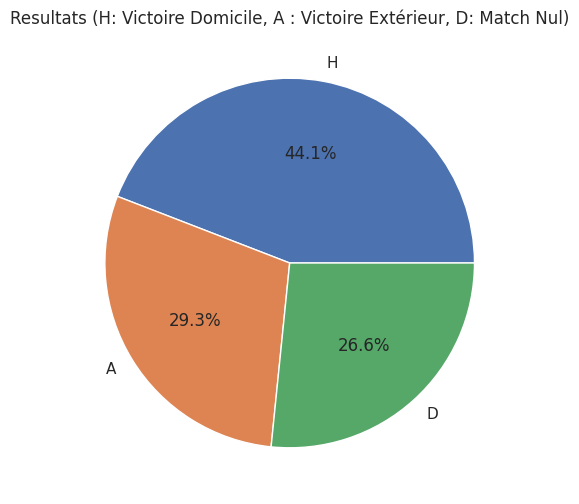

In [16]:
# Partie Analyse - Répartition des resultats de fin de match
plt.figure(figsize=(9,6))

plt.pie(L1_main_stats_cotes['FTR'].value_counts(),labels=L1_main_stats_cotes['FTR'].value_counts().index, autopct="%.1f%%")
plt.title('Resultats (H: Victoire Domicile, A : Victoire Extérieur, D: Match Nul)')
plt.show()

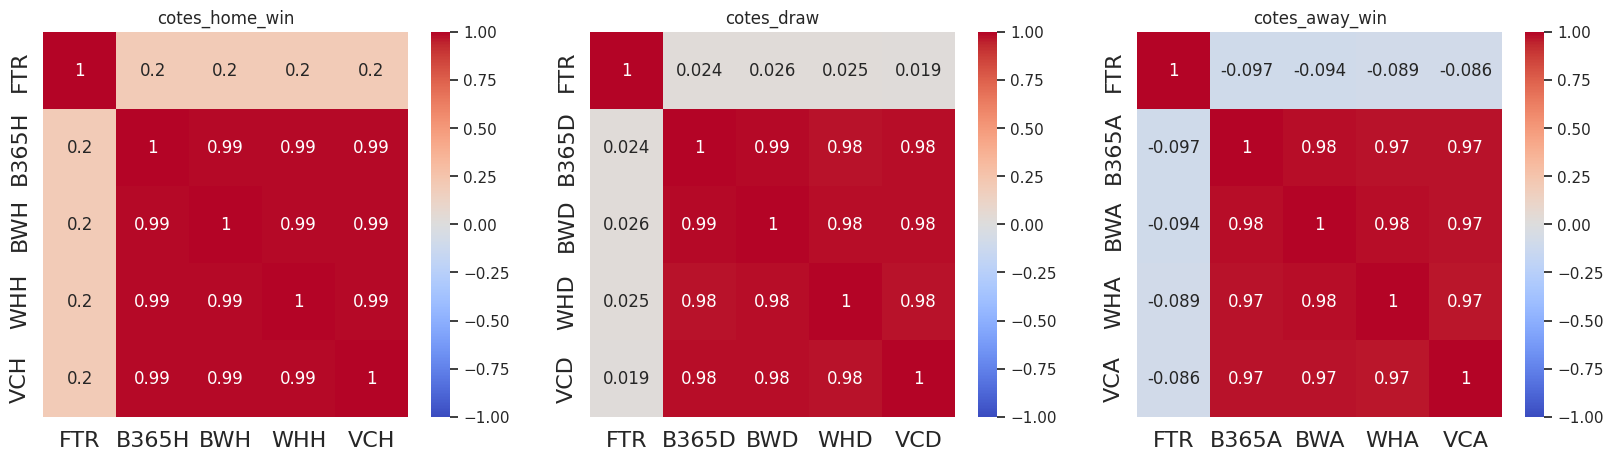

In [17]:
# Partie Analyse - Corrélation entre les cotes des bookmakers
L1_main_stats_cotes_h= L1_main_stats_cotes[['FTR','B365H','BWH','WHH','VCH']].copy()
L1_main_stats_cotes_d= L1_main_stats_cotes[['FTR','B365D','BWD','WHD','VCD']].copy()
L1_main_stats_cotes_a= L1_main_stats_cotes[['FTR','B365A','BWA','WHA','VCA']].copy()

L1_main_stats_cotes_h['FTR'].replace({'A': 2, 'D': 0, 'H': 1}, inplace=True)
L1_main_stats_cotes_d['FTR'].replace({'A': 2, 'D': 0, 'H': 1}, inplace=True)
L1_main_stats_cotes_a['FTR'].replace({'A': 2, 'D': 0, 'H': 1}, inplace=True)

vmin = -1.0
vmax = 1.0
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('cotes_home_win')
sns.heatmap(L1_main_stats_cotes_h.corr(), annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.subplot(132)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('cotes_draw')
sns.heatmap(L1_main_stats_cotes_d.corr(), annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax)

plt.subplot(133)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('cotes_away_win')
sns.heatmap(L1_main_stats_cotes_a.corr(), annot=True, cmap='coolwarm', vmin=vmin, vmax=vmax);

In [18]:
# Au vu de la corrélation entre les différents bookmaker, on ne va en garder qu'un seul dans nos dataframes
bookmaker_to_drop = ['BWH','WHH','VCH','BWD','WHD','VCD','BWA','WHA','VCA']
L1_main_stats_cotes_roulante.drop(columns=bookmaker_to_drop, inplace=True)
L1_main_stats_cotes.drop(columns=bookmaker_to_drop, inplace=True)
L1_main_stats_cotes_roulante.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_roulante.csv', index=False)
L1_main_stats_cotes.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes.csv', index=False)

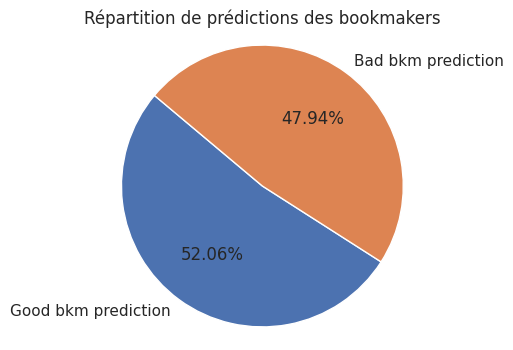

In [19]:
# Partie Analyse - Taux de bonne prédiction des bookmakers
df_bkm_predictions = L1_main_stats_cotes[['FTR','bkm_prediction']].copy()
df_bkm_predictions['bkm_is_right'] = df_bkm_predictions.apply(lambda row: 'Good bkm prediction' if (row['FTR']=='H' and row['bkm_prediction'] == 1)|(row['FTR'] == 'D' and row['bkm_prediction'] == 0)|(row['FTR'] == 'A' and row['bkm_prediction'] == 2) else 'Bad bkm prediction', axis=1)

counts = df_bkm_predictions['bkm_is_right'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(counts, labels=counts.index, autopct='%1.2f%%', startangle=140)
plt.title('Répartition de prédictions des bookmakers')
plt.axis('equal')
plt.show()

In [20]:
########################
# Travail sur Ligue1_ELO_data.csv #
########################

In [21]:
L1_elo = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/Ligue1_ELO_data_raw.csv', encoding='utf-8', sep=",", parse_dates=['From','To'])])

In [22]:
########################
# On clean une première fois #
########################

In [23]:
L1_elo = L1_elo[(L1_elo["Level"]!=0)&(L1_elo["Country"]=="FRA")].reset_index(drop=True)
remplacements = {'Gazelec': 'Ajaccio GFCO', 'ParisSG': 'Paris SG', 'Saint-Etienne': 'St Etienne', 'Evian TG':'Evian Thonon Gaillard'}
L1_elo['Club'] = L1_elo['Club'].replace(remplacements)

In [24]:
########################
# Merge L1_main_stats_cotes_roulante + Elo #
# Merge L1_main_stats_cotes + Elo          #
########################

In [25]:
# L1_main_stats_cotes_roulante + Elo
df_merge_roulant = pd.merge(L1_main_stats_cotes_roulante, L1_elo[['Club','To','Country','Elo']], how="inner", left_on=['HomeTeam','Date'], right_on=['Club',"To"],suffixes=('', '_Home'))
df_merge_roulant = pd.merge(df_merge_roulant, L1_elo[['Club','To','Country','Elo']], how="inner", left_on=['AwayTeam','Date'], right_on=['Club',"To"],suffixes=('', '_Away'))
columns_to_drop = ['Club', 'To', 'Club_Away', 'To_Away']
columns_to_rename = {'Country': 'Country_Home', 'Elo': 'Elo_Home'}
df_merge_roulant = df_merge_roulant.drop(columns=columns_to_drop)
df_merge_roulant = df_merge_roulant.rename(columns=columns_to_rename)

In [26]:
# L1_main_stats_cotes + Elo
df_merge = pd.merge(L1_main_stats_cotes, L1_elo[['Club','To','Country','Elo']], how="inner", left_on=['HomeTeam','Date'], right_on=['Club',"To"],suffixes=('', '_Home'))
df_merge = pd.merge(df_merge, L1_elo[['Club','To','Country','Elo']], how="inner", left_on=['AwayTeam','Date'], right_on=['Club',"To"],suffixes=('', '_Away'))
columns_to_drop = ['Club', 'To', 'Club_Away', 'To_Away']
columns_to_rename = {'Country': 'Country_Home', 'Elo': 'Elo_Home'}
df_merge = df_merge.drop(columns=columns_to_drop)
df_merge = df_merge.rename(columns=columns_to_rename)
df_merge = df_merge.dropna()

In [27]:
# création intervals et labels pour un pd.cut() sur la diff d'elo entre les equipes domicile et extérieur
intervals = [-float('inf'),-415,-359,-303,-247,-190,-134,-78,-22,34,90,146,202,259,315,371,float('inf')]
labels = [']<-415]', ']-415 to -359]', ']-359 to -303]', ']-303 to -247]', ']-247 to -190]',']-190 to -134]',']-134 to -78]',']-78 to -22]',
          ']-22 to 34]', ']34 to 90]', ']90 to 146]', ']146 to 202]',']202 to 259]',']259 to 315]',']315 to 371]','>371']

In [28]:
# création colonnes dans df_merge_roulant à partir des elo
df_merge_roulant['elo_diff']=df_merge_roulant['Elo_Home']-df_merge_roulant['Elo_Away']
cut_result = pd.cut(df_merge_roulant['elo_diff'], bins=intervals, labels=labels)
df_merge_roulant['elo_diff_cuted'] = cut_result

In [29]:
# création colonnes dans df_merge à partir des elo
df_merge['elo_diff']=df_merge['Elo_Home']-df_merge['Elo_Away']
cut_result = pd.cut(df_merge['elo_diff'], bins=intervals, labels=labels)
df_merge['elo_diff_cuted'] = cut_result

In [30]:
df_merge_roulant.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_roulante.csv', index=False)
df_merge.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo.csv', index=False)

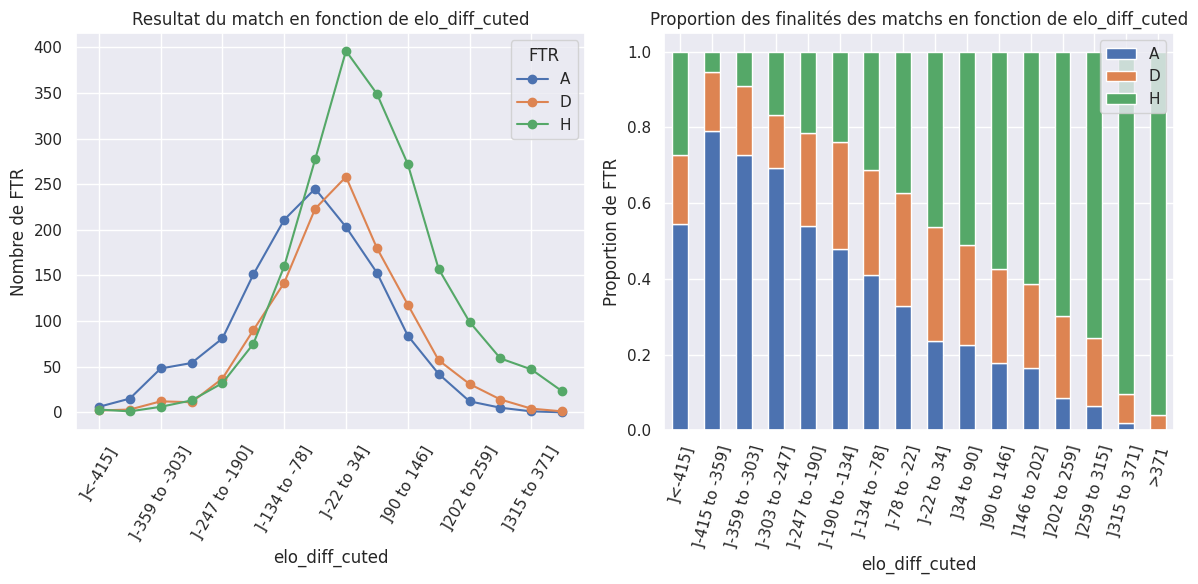

In [31]:
# Partie Analyse - Elo
import matplotlib.pyplot as plt

df_elo = df_merge
# Grouper les données par elo_diff_cuted et FTR, puis compter le nombre de chaque combinaison
counts = df_elo.groupby(['elo_diff_cuted', 'FTR']).size().unstack()

# Diviser chaque valeur par la somme respective de chaque groupe elo_diff_cuted pour obtenir les proportions
counts = counts.div(counts.sum(axis=1), axis=0)

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Tracer le premier graphique en utilisant une courbe pour chaque valeur de FTR
counts_line = df_elo.groupby(['elo_diff_cuted', 'FTR']).size().unstack()
counts_line.plot(kind='line', marker='o', ax=axes[0])
axes[0].set_xlabel('elo_diff_cuted')
axes[0].set_ylabel('Nombre de FTR')
axes[0].set_title('Resultat du match en fonction de elo_diff_cuted')
axes[0].legend(title='FTR')
xlabels = axes[0].get_xticklabels()
axes[0].set_xticklabels(xlabels, rotation=60)
axes[0].grid(True)

# Tracer le second graphique à barres empilées
graph = counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('elo_diff_cuted')
axes[1].set_ylabel('Proportion de FTR')
axes[1].set_title('Proportion des finalités des matchs en fonction de elo_diff_cuted')

# Déplacer la légende du deuxième sous-graphique vers le coin supérieur droit
graph.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

xlabels = axes[1].get_xticklabels()
axes[1].set_xticklabels(xlabels, rotation=75)

# Activer la grille
axes[1].grid(True)

# Afficher la figure
plt.tight_layout()
plt.show()

In [32]:
########################
# Stats sur 5 games #
########################

In [33]:
df_merge_roulant = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_roulante.csv', encoding='utf-8', sep=",", parse_dates=['Date'])])
df_merge = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo.csv', encoding='utf-8', sep=",", parse_dates=['Date'])])

In [34]:
df_last_5_games = stats_last_3_and_5_matchs(df_merge_roulant[['Date','HomeTeam','AwayTeam','FTR']])
df_last_5_games = df_last_5_games.drop(['HomeTeam','AwayTeam','FTR','victoire','defaite'], axis=1)

In [35]:
# Roulant - L1_main_stats_cotes_elo_roulant + Stats sur 5 games
df_merge_roulant = pd.merge(df_merge_roulant, df_last_5_games, how="left", left_on=['HomeTeam','Date'], right_on=['team_series',"Date"],suffixes=('', '_Home'))
df_merge_roulant = pd.merge(df_merge_roulant, df_last_5_games, how="left", left_on=['AwayTeam','Date'], right_on=['team_series',"Date"],suffixes=('', '_Away'))
columns_to_drop = ['team_series', 'team_series_Away']
columns_to_rename = {"sum_win_last_5":"sum_win_last_5_Home", "sum_lose_last_5":"sum_lose_last_5_Home", "sum_win_last_3":"sum_win_last_3_Home", "sum_lose_last_3":"sum_lose_last_3_Home"}
df_merge_roulant = df_merge_roulant.rename(columns=columns_to_rename)
df_merge_roulant = df_merge_roulant.drop(columns=columns_to_drop)

In [36]:
# Non Roulant - L1_main_stats_cotes_elo + Stats sur 5 games
df_merge = pd.merge(df_merge, df_last_5_games, how="left", left_on=['HomeTeam','Date'], right_on=['team_series',"Date"],suffixes=('', '_Home'))
df_merge = pd.merge(df_merge, df_last_5_games, how="left", left_on=['AwayTeam','Date'], right_on=['team_series',"Date"],suffixes=('', '_Away'))
columns_to_drop = ['team_series', 'team_series_Away']
columns_to_rename = {"sum_win_last_5":"sum_win_last_5_Home", "sum_lose_last_5":"sum_lose_last_5_Home", "sum_win_last_3":"sum_win_last_3_Home", "sum_lose_last_3":"sum_lose_last_3_Home"}
df_merge = df_merge.rename(columns=columns_to_rename)
df_merge = df_merge.drop(columns=columns_to_drop)

In [37]:
df_merge_roulant.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_5games_roulante.csv', index=False)
df_merge.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_5games.csv', index=False)

In [38]:
########################
# Travail sur L1_joueurs_raw.csv #
########################

In [39]:
L1_joueurs = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_raw.csv', encoding='utf-8', sep=",", low_memory=False)])

In [40]:
########################
# On clean une première fois #
########################

In [41]:
remplacements = {'GFC Ajaccio': 'Ajaccio GFCO', 'Saint-Etienne': 'St Etienne', 'AS Monaco':'Monaco'}
L1_joueurs["localteam.name"] = L1_joueurs["localteam.name"].replace(remplacements)
L1_joueurs["visitorteam.name"] = L1_joueurs["visitorteam.name"].replace(remplacements)
L1_joueurs = L1_joueurs[L1_joueurs["pos"]!="SUB"] # il n'y a que 3 lignes dans les data L1
L1_joueurs['Date'] = L1_joueurs.apply(lambda row: consolidate_date(row['season'], row['date']), axis=1)
L1_joueurs = L1_joueurs.drop(columns=['Unnamed: 0', 'date'])
L1_joueurs["minutes_played"] = L1_joueurs["minutes_played"].apply(lambda x: int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 0)
L1_joueurs = L1_joueurs[L1_joueurs['minutes_played']>0]
L1_joueurs["rating"] = L1_joueurs["rating"].apply(lambda x: float(re.search(r'\d+\.\d+', str(x)).group()) if re.search(r'\d+\.\d+', str(x)) else 0)

In [42]:
L1_joueurs_grouped = L1_joueurs.copy()
L1_joueurs_grouped['pos'].replace({'SUB_G': 'G', 'SUB_D': 'D', 'SUB_M': 'M', 'SUB_F':'F'}, inplace=True)
L1_joueurs_grouped = L1_joueurs_grouped[(L1_joueurs_grouped['pos']=='G')|(L1_joueurs_grouped['pos']=='D')|(L1_joueurs_grouped['pos']=='M')|(L1_joueurs_grouped['pos']=='F')]

In [43]:
# Calcul de la médiane par groupe dans 'rating' quand minutes_played est en dessous de 8min
median_by_group = L1_joueurs_grouped[L1_joueurs_grouped['minutes_played']>8].groupby(['leagueName','Date','team','localteam.name','visitorteam.name','pos'])['rating'].median()
for (group_leagueName,group_Date,group_team,group_localteam,group_visitorteam,group_pos), median_value in median_by_group.items():
    L1_joueurs_grouped.loc[(L1_joueurs_grouped['rating'] == 0) & (L1_joueurs_grouped['minutes_played'] > 0) & (L1_joueurs_grouped['minutes_played'] <= 8) &
     (L1_joueurs_grouped['leagueName'] == group_leagueName) &
     (L1_joueurs_grouped['Date'] == group_Date) &
     (L1_joueurs_grouped['team'] == group_team) &
     (L1_joueurs_grouped['localteam.name'] == group_localteam) &
     (L1_joueurs_grouped['visitorteam.name'] == group_visitorteam) &
     (L1_joueurs_grouped['pos'] == group_pos), 'rating'] = median_value
L1_joueurs_grouped = L1_joueurs_grouped.reset_index(drop=True)

In [44]:
for index, row in L1_joueurs_grouped.iterrows():
    if '%' in str(row['passes_acc']):
        L1_joueurs_grouped.at[index, 'passes_acc'] = row['passes'] * float(row['passes_acc'].rstrip('%')) / 100
    else:
        None

In [45]:
L1_joueurs_grouped.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_raw_first_clean.csv', index=False)

In [46]:
L1_joueurs_grouped = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_raw_first_clean.csv', encoding='utf-8', sep=",", low_memory=False)])

In [47]:
L1_joueurs_grouped = L1_joueurs_grouped.fillna(0)

In [48]:
# Définition des pondérations pour chaque position
ponderations = {
    'G': {'saves': 0.3, 'savesInsideBox': 0.25, 'pen_save': 0.15, 'punches': 0.1, 'clearances': 0.1, 'passes_acc': 0.05, 'errors_leading_to_goal': -0.05},
    'D': {'tackles': 0.2, 'interceptions': 0.15, 'aerials_won': 0.15, 'clearances': 0.15, 'passes_acc': 0.1, 'keyPasses': 0.05, 'errors_leading_to_goal': -0.05, 'goals': 0.1, 'assists': 0.05},
    'M': {'passes_acc': 0.2, 'tackles': 0.15, 'keyPasses': 0.15, 'interceptions': 0.1, 'aerials_won': 0.1, 'dribbleSucc': 0.1, 'goals': 0.1, 'assists': 0.1},
    'F': {'goals': 0.4, 'shots_on_goal':0.2, 'assists': 0.2, 'keyPasses': 0.04, 'dribbleSucc': 0.04, 'aerials_won': 0.04, 'passes_acc': 0.04, 'tackles': 0.04}
                }

# Fonction pour calculer le score en fonction des pondérations et des statistiques du joueur
def calculer_score(row):
    position = row['pos']
    if position in ponderations:
        score = sum(row[stat] * weight for stat, weight in ponderations[position].items() if stat in row)
        return score
    return None

In [57]:
L1_joueurs_grouped = L1_joueurs_grouped.fillna(0)
L1_joueurs_grouped = L1_joueurs_grouped.groupby(['leagueName','Date','team','localteam.name','visitorteam.name','pos']).agg({
    'shots_total': 'sum',
    'shots_on_goal': 'sum',
    'offsides': 'sum',
    'fouls_drawn': 'sum',
    'fouls_commited': 'sum',
    'tackles': 'sum',
    'blocks': 'sum',
    'total_crosses': 'sum',
    'acc_crosses': 'sum',
    'interceptions': 'sum',
    'clearances': 'sum',
    'dispossesed': 'sum',
    'saves': 'sum',
    'punches': 'sum',
    'savesInsideBox': 'sum',
    'duelsTotal': 'sum',
    'duelsWon': 'sum',
    'aerials_won': 'sum',
    'dribbleAttempts': 'sum',
    'dribbleSucc': 'sum',
    'dribbledPast': 'sum',
    'yellowcards': 'sum',
    'big_chance_created': 'sum',
    'big_chance_missed': 'sum',
    'good_high_claim': 'sum',
    'clearance_offine': 'sum',
    'error_lead_to_goal': 'sum',
    'lastman_tackle': 'sum',
    'redcards': 'sum',
    'pen_score': 'sum',
    'pen_miss': 'sum',
    'pen_save': 'sum',
    'pen_committed': 'sum',
    'pen_won': 'sum',
    'hit_woodwork': 'sum',
    'passes': 'sum',
    'passes_acc': 'sum',
    'keyPasses': 'sum',
    'minutes_played': 'sum',
    'rating': 'mean',
    # 'score_joueur':'mean',
    # 'score_joueur_avg_of_week':'mean',
    # 'diff_with_avg':'mean'
}).reset_index()

In [58]:
# Application de la fonction pour calculer le score et l'ajouter comme nouvelle colonne
L1_joueurs_grouped['score_pos'] = L1_joueurs_grouped.apply(calculer_score, axis=1)

In [59]:
L1_joueurs_grouped['Date'] = pd.to_datetime(L1_joueurs_grouped['Date'])
L1_joueurs_grouped['semaine'] = L1_joueurs_grouped['Date'].dt.strftime('%U')
L1_joueurs_grouped['year'] = L1_joueurs_grouped['Date'].dt.year

In [61]:
moyennes_par_position_et_date = L1_joueurs_grouped.copy()
moyennes_par_position_et_date = moyennes_par_position_et_date.groupby(['semaine','year','team', 'pos'])['score_pos'].mean().reset_index()
moyennes_par_position_et_date.rename(columns={'score_pos': 'score_pos_avg_grouped_date_h_or_a_and_pos'}, inplace=True)

In [62]:
L1_joueurs_grouped = pd.merge(L1_joueurs_grouped, moyennes_par_position_et_date, how="left", left_on=['semaine','year','pos','team'], right_on=['semaine','year','pos','team'])
L1_joueurs_grouped['diff_with_avg']=L1_joueurs_grouped['score_pos']-L1_joueurs_grouped['score_pos_avg_grouped_date_h_or_a_and_pos']

In [63]:
L1_joueurs_grouped["team_stats"] = np.where(L1_joueurs_grouped["team"] == "localteam", L1_joueurs_grouped["localteam.name"], L1_joueurs_grouped["visitorteam.name"])
L1_joueurs_grouped["at_home"] = np.where(L1_joueurs_grouped["team"] == "localteam", 1, 0)

# Réorganisation des colonnes dans l'ordre souhaité
nouvel_ordre_colonnes = ['team_stats','Date','at_home','leagueName','localteam.name','visitorteam.name','pos',
                        'shots_total','shots_on_goal','offsides','fouls_drawn','fouls_commited','tackles','blocks','total_crosses','acc_crosses','interceptions','clearances','dispossesed','saves','punches','savesInsideBox','duelsTotal','duelsWon','aerials_won','dribbleAttempts','dribbleSucc','dribbledPast','yellowcards','big_chance_created','big_chance_missed','good_high_claim','clearance_offine','error_lead_to_goal','lastman_tackle','redcards','pen_score','pen_miss','pen_save','pen_committed','pen_won','hit_woodwork','passes','passes_acc','keyPasses','rating','minutes_played','score_pos','score_pos_avg_grouped_date_h_or_a_and_pos','diff_with_avg'
                        ]
L1_joueurs_grouped = L1_joueurs_grouped[nouvel_ordre_colonnes]
L1_joueurs_grouped = L1_joueurs_grouped.sort_values(by=['team_stats', 'pos', 'Date']).reset_index(drop=True)


In [64]:
L1_joueurs_grouped.head(5)

,team_stats,Date,at_home,leagueName,localteam.name,visitorteam.name,pos,shots_total,shots_on_goal,offsides,fouls_drawn,fouls_commited,tackles,blocks,total_crosses,acc_crosses,interceptions,clearances,dispossesed,saves,punches,savesInsideBox,duelsTotal,duelsWon,aerials_won,dribbleAttempts,dribbleSucc,dribbledPast,yellowcards,big_chance_created,big_chance_missed,good_high_claim,clearance_offine,error_lead_to_goal,lastman_tackle,redcards,pen_score,pen_miss,pen_save,pen_committed,pen_won,hit_woodwork,passes,passes_acc,keyPasses,rating,minutes_played,score_pos,score_pos_avg_grouped_date_h_or_a_and_pos,diff_with_avg
0,Ajaccio,2022-08-05,0,France: Ligue 1,Lyon,Ajaccio,D,0.0,0.0,0.0,4.0,6.0,7.0,1.0,2.0,1.0,7.0,5.0,1.0,0.0,0.0,0.0,28.0,14.0,2.0,5.0,1.0,3.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,1.0,0.0,0.0,107.0,83.0,1.0,6.275,360,11.85,15.650000,-3.800000
1,Ajaccio,2022-08-14,1,France: Ligue 1,Ajaccio,Lens,D,1.0,0.0,0.0,5.0,3.0,4.0,0.0,2.0,1.0,5.0,13.0,2.0,0.0,0.0,0.0,28.0,15.0,5.0,2.0,1.0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,106.0,85.0,1.0,6.840,366,12.80,19.842857,-7.042857
2,Ajaccio,2022-08-21,0,France: Ligue 1,Rennes,Ajaccio,D,1.0,0.0,0.0,2.0,5.0,6.0,2.0,6.0,0.0,7.0,8.0,1.0,0.0,0.0,0.0,46.0,23.0,14.0,4.0,1.0,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,1.0,0.0,168.0,128.0,0.0,6.480,364,18.35,22.010000,-3.660000
3,Ajaccio,2022-08-26,1,France: Ligue 1,Ajaccio,Lille,D,1.0,0.0,1.0,5.0,6.0,5.0,0.0,7.0,1.0,3.0,6.0,2.0,0.0,0.0,0.0,35.0,16.0,4.0,2.0,2.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1.0,135.0,113.0,2.0,6.375,333,14.35,22.200000,-7.850000
4,Ajaccio,2022-08-31,0,France: Ligue 1,Montpellier,Ajaccio,D,4.0,0.0,0.0,1.0,6.0,9.0,2.0,7.0,2.0,4.0,9.0,2.0,0.0,0.0,0.0,34.0,21.0,11.0,1.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,193.0,162.0,2.0,6.850,349,21.70,19.462500,2.237500


In [65]:
column_indices = list(range(7, len(L1_joueurs_grouped.columns)))
L1_joueurs_grouped = L1_joueurs_grouped.groupby(['leagueName','team_stats','at_home','pos'], group_keys=False).apply(lambda x: mean_deroulante(x, column_indices, window_size))
# L1_joueurs_grouped = L1_joueurs_grouped.dropna(subset=['minutes_played'])

In [66]:
# L1_joueurs_grouped.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_grouped_roulante.csv', index=False)
L1_joueurs_grouped.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_grouped_roulante_with2024.csv', index=False)

In [67]:
# L1_joueurs_grouped_roulante = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_grouped_roulante.csv', encoding='utf-8', sep=",", low_memory=False)])
L1_joueurs_grouped_roulante = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_grouped_roulante_with2024.csv', encoding='utf-8', sep=",", low_memory=False)])

In [68]:
# L1_joueurs_grouped_roulante.sort_values(by=['Date']).tail(10)

In [69]:
roulant = True
first_col_to_modify = 6
####
#### split match à domicile / match à l'extérieur
L1_joueurs_home = L1_joueurs_grouped_roulante[L1_joueurs_grouped_roulante["at_home"]==1]
L1_joueurs_away = L1_joueurs_grouped_roulante[L1_joueurs_grouped_roulante["at_home"]==0]
#### split par pos
## Home
df_h_g = L1_joueurs_home[L1_joueurs_home["pos"]=="G"]
colonnes_a_modifier = df_h_g.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_h_g' for colonne in colonnes_a_modifier}
df_h_g = df_h_g.rename(columns=mapping_colonnes)

df_h_d = L1_joueurs_home[L1_joueurs_home["pos"]=="D"]
colonnes_a_modifier = df_h_d.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_h_d' for colonne in colonnes_a_modifier}
df_h_d = df_h_d.rename(columns=mapping_colonnes)

df_h_f = L1_joueurs_home[L1_joueurs_home["pos"]=="F"]
colonnes_a_modifier = df_h_f.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_h_f' for colonne in colonnes_a_modifier}
df_h_f = df_h_f.rename(columns=mapping_colonnes)

df_h_m = L1_joueurs_home[L1_joueurs_home["pos"]=="M"]
colonnes_a_modifier = df_h_m.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_h_m' for colonne in colonnes_a_modifier}
df_h_m = df_h_m.rename(columns=mapping_colonnes)

## Away
df_a_g = L1_joueurs_away[L1_joueurs_away["pos"]=="G"]
colonnes_a_modifier = df_a_g.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_a_g' for colonne in colonnes_a_modifier}
df_a_g = df_a_g.rename(columns=mapping_colonnes)

df_a_d = L1_joueurs_away[L1_joueurs_away["pos"]=="D"]
colonnes_a_modifier = df_a_d.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_a_d' for colonne in colonnes_a_modifier}
df_a_d = df_a_d.rename(columns=mapping_colonnes)

df_a_f = L1_joueurs_away[L1_joueurs_away["pos"]=="F"]
colonnes_a_modifier = df_a_f.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_a_f' for colonne in colonnes_a_modifier}
df_a_f = df_a_f.rename(columns=mapping_colonnes)

df_a_m = L1_joueurs_away[L1_joueurs_away["pos"]=="M"]
colonnes_a_modifier = df_a_m.columns[first_col_to_modify:]
mapping_colonnes = {colonne: f'{colonne}_a_m' for colonne in colonnes_a_modifier}
df_a_m = df_a_m.rename(columns=mapping_colonnes)

dfs_h = [df_h_d,df_h_g,df_h_f,df_h_m]
dfs_a = [df_a_d,df_a_g,df_a_f,df_a_m]

L1_joueurs_home = reduce(lambda left, right: pd.merge(left, right, on=['team_stats', 'Date', 'at_home', 'leagueName', 'localteam.name', 'visitorteam.name'], how='outer'),dfs_h)
L1_joueurs_away = reduce(lambda left, right: pd.merge(left, right, on=['team_stats', 'Date', 'at_home', 'leagueName', 'localteam.name', 'visitorteam.name'], how='outer'),dfs_a)

columns_to_drop = ['team_stats', 'at_home']
L1_joueurs_home = L1_joueurs_home.drop(columns=columns_to_drop)
L1_joueurs_away = L1_joueurs_away.drop(columns=columns_to_drop)

L1_joueurs_final = pd.merge(L1_joueurs_home, L1_joueurs_away, how="outer", left_on=['localteam.name','Date','visitorteam.name'], right_on=['localteam.name',"Date",'visitorteam.name'])
L1_joueurs_final = L1_joueurs_final.rename(columns={"leagueName_x":"leagueName_h","leagueName_y":"leagueName_a"})
L1_joueurs_final = L1_joueurs_final.dropna(subset=['pos_h_g','pos_h_d','pos_h_m','pos_h_f','pos_a_g','pos_a_d','pos_a_m','pos_a_f'])

In [70]:
# L1_joueurs_final.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_final.csv', index=False)
L1_joueurs_final.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_final_with_2024.csv', index=False)

In [71]:
L1_joueurs_final.sort_values(by=['Date']).tail(5)

,Date,leagueName_h,localteam.name,visitorteam.name,pos_h_d,shots_total_h_d,shots_on_goal_h_d,offsides_h_d,fouls_drawn_h_d,fouls_commited_h_d,tackles_h_d,blocks_h_d,total_crosses_h_d,acc_crosses_h_d,interceptions_h_d,clearances_h_d,dispossesed_h_d,saves_h_d,punches_h_d,savesInsideBox_h_d,duelsTotal_h_d,duelsWon_h_d,aerials_won_h_d,dribbleAttempts_h_d,dribbleSucc_h_d,dribbledPast_h_d,yellowcards_h_d,big_chance_created_h_d,big_chance_missed_h_d,good_high_claim_h_d,clearance_offine_h_d,error_lead_to_goal_h_d,lastman_tackle_h_d,redcards_h_d,pen_score_h_d,pen_miss_h_d,pen_save_h_d,pen_committed_h_d,pen_won_h_d,hit_woodwork_h_d,passes_h_d,passes_acc_h_d,keyPasses_h_d,rating_h_d,minutes_played_h_d,score_pos_h_d,score_pos_avg_grouped_date_h_or_a_and_pos_h_d,diff_with_avg_h_d,pos_h_g,shots_total_h_g,shots_on_goal_h_g,offsides_h_g,fouls_drawn_h_g,fouls_commited_h_g,tackles_h_g,blocks_h_g,total_crosses_h_g,acc_crosses_h_g,interceptions_h_g,clearances_h_g,dispossesed_h_g,saves_h_g,punches_h_g,savesInsideBox_h_g,duelsTotal_h_g,duelsWon_h_g,aerials_won_h_g,dribbleAttempts_h_g,dribbleSucc_h_g,dribbledPast_h_g,yellowcards_h_g,big_chance_created_h_g,big_chance_missed_h_g,good_high_claim_h_g,clearance_offine_h_g,error_lead_to_goal_h_g,lastman_tackle_h_g,redcards_h_g,pen_score_h_g,pen_miss_h_g,pen_save_h_g,pen_committed_h_g,pen_won_h_g,hit_woodwork_h_g,passes_h_g,passes_acc_h_g,keyPasses_h_g,rating_h_g,minutes_played_h_g,score_pos_h_g,score_pos_avg_grouped_date_h_or_a_and_pos_h_g,diff_with_avg_h_g,pos_h_f,shots_total_h_f,shots_on_goal_h_f,offsides_h_f,fouls_drawn_h_f,fouls_commited_h_f,tackles_h_f,blocks_h_f,...,pen_save_a_g,pen_committed_a_g,pen_won_a_g,hit_woodwork_a_g,passes_a_g,passes_acc_a_g,keyPasses_a_g,rating_a_g,minutes_played_a_g,score_pos_a_g,score_pos_avg_grouped_date_h_or_a_and_pos_a_g,diff_with_avg_a_g,pos_a_f,shots_total_a_f,shots_on_goal_a_f,offsides_a_f,fouls_drawn_a_f,fouls_commited_a_f,tackles_a_f,blocks_a_f,total_crosses_a_f,acc_crosses_a_f,interceptions_a_f,clearances_a_f,dispossesed_a_f,saves_a_f,punches_a_f,savesInsideBox_a_f,duelsTotal_a_f,duelsWon_a_f,aerials_won_a_f,dribbleAttempts_a_f,dribbleSucc_a_f,dribbledPast_a_f,yellowcards_a_f,big_chance_created_a_f,big_chance_missed_a_f,good_high_claim_a_f,clearance_offine_a_f,error_lead_to_goal_a_f,lastman_tackle_a_f,redcards_a_f,pen_score_a_f,pen_miss_a_f,pen_save_a_f,pen_committed_a_f,pen_won_a_f,hit_woodwork_a_f,passes_a_f,passes_acc_a_f,keyPasses_a_f,rating_a_f,minutes_played_a_f,score_pos_a_f,score_pos_avg_grouped_date_h_or_a_and_pos_a_f,diff_with_avg_a_f,pos_a_m,shots_total_a_m,shots_on_goal_a_m,offsides_a_m,fouls_drawn_a_m,fouls_commited_a_m,tackles_a_m,blocks_a_m,total_crosses_a_m,acc_crosses_a_m,interceptions_a_m,clearances_a_m,dispossesed_a_m,saves_a_m,punches_a_m,savesInsideBox_a_m,duelsTotal_a_m,duelsWon_a_m,aerials_won_a_m,dribbleAttempts_a_m,dribbleSucc_a_m,dribbledPast_a_m,yellowcards_a_m,big_chance_created_a_m,big_chance_missed_a_m,good_high_claim_a_m,clearance_offine_a_m,error_lead_to_goal_a_m,lastman_tackle_a_m,redcards_a_m,pen_score_a_m,pen_miss_a_m,pen_save_a_m,pen_committed_a_m,pen_won_a_m,hit_woodwork_a_m,passes_a_m,passes_acc_a_m,keyPasses_a_m,rating_a_m,minutes_played_a_m,score_pos_a_m,score_pos_avg_grouped_date_h_or_a_and_pos_a_m,diff_with_avg_a_m
1641,2023-10-08,France: Ligue 1,Rennes,Paris SG,D,2.666667,1.000000,0.666667,4.333333,2.666667,5.333333,1.333333,4.333333,0.666667,5.000000,6.333333,2.000000,0.0,0.0,0.0,32.333333,19.000000,7.000000,4.000000,2.666667,2.000000,0.333333,0.333333,0.333333,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000,246.666667,219.666667,2.000000,7.073333,387.333333,25.883333,23.794444,2.088889,G,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,2.333333,0.666667,1.666667,0.666667,0.666667,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.333333,34.000000,0.0,4.533333,95.333333,2.950000,2.872222,0.077778,F,1.666667,1.000000,0.666667,4.000000,1.333333,2.000000,

In [72]:
########################
#  Merge main_df + L1_joueurs_final #
########################
L1_main_stats_cotes_elo_roulante = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_5games_roulante.csv', encoding='utf-8', sep=",", parse_dates=['Date'])])
# L1_joueurs_final = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_final.csv', encoding='utf-8', sep=",", parse_dates=['Date'])])
L1_joueurs_final = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_final_with_2024.csv', encoding='utf-8', sep=",", parse_dates=['Date'])])

L1_joueurs_final['Date'] = pd.to_datetime(L1_joueurs_final['Date'], format='%Y-%m-%d')
L1_main_stats_cotes_elo_roulante = L1_main_stats_cotes_elo_roulante[(L1_main_stats_cotes_elo_roulante['Date']>=L1_joueurs_final['Date'].min())&(L1_main_stats_cotes_elo_roulante['Date']<=L1_joueurs_final['Date'].max())]

L1_main_stats_cotes_elo_joueurs_roulante = pd.merge(L1_main_stats_cotes_elo_roulante, L1_joueurs_final, how="inner", left_on=['HomeTeam','Date','AwayTeam'], right_on=['localteam.name',"Date","visitorteam.name"]) #,suffixes=('_cote', '_details'))
L1_main_stats_cotes_elo_joueurs_roulante['num_of_day'] = L1_main_stats_cotes_elo_joueurs_roulante['Date'].dt.dayofweek

In [74]:
# L1_main_stats_cotes_elo_joueurs_roulante.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_joueurs_roulante.csv', index=False)
L1_main_stats_cotes_elo_joueurs_roulante.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_joueurs_roulante_with_2024.csv', index=False)

In [75]:
########################
# Travail sur les dimensions #
########################

In [151]:
# main_df_roulant = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_joueurs_roulante.csv', encoding='utf-8', sep=",", parse_dates=['Date'])
main_df_roulant = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_joueurs_roulante_with_2024.csv', encoding='utf-8', sep=",", parse_dates=['Date'])
# main_df_roulant = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_5games_roulante.csv', encoding='utf-8', sep=",", parse_dates=['Date'])
# main_df_roulant = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_roulante.csv', encoding='utf-8', sep=",", parse_dates=['Date'])

In [152]:
main_df_roulant = main_df_roulant.drop(columns=['HTR']) # fuite data
main_df_roulant = main_df_roulant.sort_values(by=['Date']).reset_index(drop=True)
cote = main_df_roulant.copy()
cote.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/cote_for_streamlit.csv', index=False)
main_df_roulant = main_df_roulant.drop(columns=['Div','Date','Country_Home','Country_Away','localteam.name','visitorteam.name','leagueName_h','leagueName_a'])
main_df_roulant = main_df_roulant.drop(columns=['pos_h_g','pos_h_d','pos_h_m','pos_h_f','pos_a_g','pos_a_d','pos_a_m','pos_a_f'])
# main_df_roulant = main_df_roulant.drop(columns=['leagueName_h','localteam.name','visitorteam.name'])
main_df_roulant['FTR'] = main_df_roulant['FTR'].replace({'A': 2, 'D': 0, 'H': 1})
# main_df_roulant = main_df_roulant[~(main_df_roulant['FTR']==0)]
# main_df_roulant['FTR'] = main_df_roulant['FTR'].replace({2:0})
# main_df_roulant.head(3)

In [153]:
# création colonnes dans df_merge_roulant à partir des elo
cut_result = pd.cut(main_df_roulant['diff_with_avg_a_m'], bins=16)
main_df_roulant['diff_with_avg_a_m_cuted'] = cut_result
cut_result = pd.cut(main_df_roulant['diff_with_avg_h_m'], bins=16)
main_df_roulant['diff_with_avg_h_m_cuted'] = cut_result
cut_result = pd.cut(main_df_roulant['diff_with_avg_a_d'], bins=16)
main_df_roulant['diff_with_avg_a_d_cuted'] = cut_result
cut_result = pd.cut(main_df_roulant['diff_with_avg_h_d'], bins=16)
main_df_roulant['diff_with_avg_h_d_cuted'] = cut_result
cut_result = pd.cut(main_df_roulant['diff_with_avg_a_f'], bins=16)
main_df_roulant['diff_with_avg_a_f_cuted'] = cut_result
cut_result = pd.cut(main_df_roulant['diff_with_avg_h_f'], bins=16)
main_df_roulant['diff_with_avg_h_f_cuted'] = cut_result
cut_result = pd.cut(main_df_roulant['diff_with_avg_a_g'], bins=16)
main_df_roulant['diff_with_avg_a_g_cuted'] = cut_result
cut_result = pd.cut(main_df_roulant['diff_with_avg_h_g'], bins=16)
main_df_roulant['diff_with_avg_h_g_cuted'] = cut_result

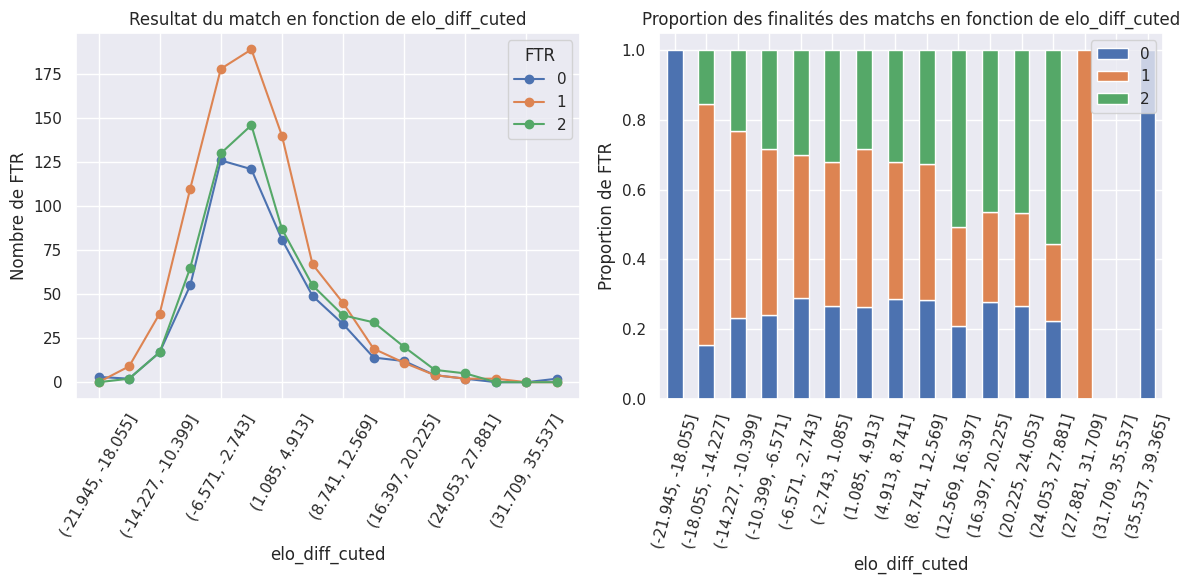

In [154]:
# Partie Analyse - Elo
import matplotlib.pyplot as plt
col = 'diff_with_avg_a_m_cuted'
df_elo = main_df_roulant.copy()
# Grouper les données par elo_diff_cuted et FTR, puis compter le nombre de chaque combinaison
counts = df_elo.groupby([col, 'FTR']).size().unstack()

# Diviser chaque valeur par la somme respective de chaque groupe elo_diff_cuted pour obtenir les proportions
counts = counts.div(counts.sum(axis=1), axis=0)

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Tracer le premier graphique en utilisant une courbe pour chaque valeur de FTR
counts_line = df_elo.groupby([col, 'FTR']).size().unstack()
counts_line.plot(kind='line', marker='o', ax=axes[0])
axes[0].set_xlabel('elo_diff_cuted')
axes[0].set_ylabel('Nombre de FTR')
axes[0].set_title('Resultat du match en fonction de elo_diff_cuted')
axes[0].legend(title='FTR')
xlabels = axes[0].get_xticklabels()
axes[0].set_xticklabels(xlabels, rotation=60)
axes[0].grid(True)

# Tracer le second graphique à barres empilées
graph = counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('elo_diff_cuted')
axes[1].set_ylabel('Proportion de FTR')
axes[1].set_title('Proportion des finalités des matchs en fonction de elo_diff_cuted')

# Déplacer la légende du deuxième sous-graphique vers le coin supérieur droit
graph.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

xlabels = axes[1].get_xticklabels()
axes[1].set_xticklabels(xlabels, rotation=75)

# Activer la grille
axes[1].grid(True)

# Afficher la figure
plt.tight_layout()
plt.show()

In [83]:
main_df_numerique = main_df_roulant.select_dtypes(include=['number'])
colonne_reference = 'FTR'
np.random.seed(42)
main_df_numerique['valeurs_aleatoires'] = np.random.randint(1, 10000, main_df_numerique.shape[0])
correlations = main_df_numerique.corr(numeric_only=False)[colonne_reference]
colonnes_filtrees = correlations[correlations.abs() > np.abs(correlations["valeurs_aleatoires"])].index
main_df_numerique = main_df_roulant[colonnes_filtrees]
col_non_numeriques = main_df_roulant.select_dtypes(exclude=['number']).columns
main_df_roulant = pd.concat([main_df_roulant[col_non_numeriques], main_df_roulant[main_df_numerique.columns]], axis=1)


In [84]:
main_df_roulant.shape

(1942, 141)

In [85]:
main_df_numerique = main_df_roulant.select_dtypes(include=['number'])
colonne_reference = 'FTR'
correlations = main_df_numerique.corr(numeric_only=False)[colonne_reference]
colonnes_filtrees = correlations[correlations.abs() > 0.05].index
main_df_numerique = main_df_roulant[colonnes_filtrees]
col_non_numeriques = main_df_roulant.select_dtypes(exclude=['number']).columns
main_df_roulant = pd.concat([main_df_roulant[col_non_numeriques], main_df_roulant[main_df_numerique.columns]], axis=1)

In [86]:
main_df_roulant.shape

(1942, 49)

In [90]:
########################
# Mise en place du modèle #
########################

In [92]:
from sklearn.preprocessing import LabelEncoder
le_elo_diff_cuted = LabelEncoder()
main_df_roulant['elo_diff_cuted'] = le_elo_diff_cuted.fit_transform(main_df_roulant['elo_diff_cuted'])


le_diff_with_avg_a_m_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_a_m_cuted'] = le_diff_with_avg_a_m_cuted.fit_transform(main_df_roulant['diff_with_avg_a_m_cuted'])
le_diff_with_avg_h_m_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_h_m_cuted'] = le_diff_with_avg_h_m_cuted.fit_transform(main_df_roulant['diff_with_avg_h_m_cuted'])
le_diff_with_avg_a_d_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_a_d_cuted'] = le_diff_with_avg_a_d_cuted.fit_transform(main_df_roulant['diff_with_avg_a_d_cuted'])
le_diff_with_avg_h_d_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_h_d_cuted'] = le_diff_with_avg_h_d_cuted.fit_transform(main_df_roulant['diff_with_avg_h_d_cuted'])
le_diff_with_avg_a_f_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_a_f_cuted'] = le_diff_with_avg_a_f_cuted.fit_transform(main_df_roulant['diff_with_avg_a_f_cuted'])
le_diff_with_avg_h_f_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_h_f_cuted'] = le_diff_with_avg_h_f_cuted.fit_transform(main_df_roulant['diff_with_avg_h_f_cuted'])
le_diff_with_avg_a_g_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_a_g_cuted'] = le_diff_with_avg_a_g_cuted.fit_transform(main_df_roulant['diff_with_avg_a_g_cuted'])
le_diff_with_avg_h_g_cuted = LabelEncoder()
main_df_roulant['diff_with_avg_h_g_cuted'] = le_diff_with_avg_h_g_cuted.fit_transform(main_df_roulant['diff_with_avg_h_g_cuted'])


le_season = LabelEncoder()
main_df_roulant['Season'] = le_season.fit_transform(main_df_roulant['Season'])

In [93]:
main_df_roulant = pd.get_dummies(main_df_roulant, columns=['HomeTeam', 'AwayTeam'])

In [96]:
main_df_roulant.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/last_avant_split.csv', index=False)
# main_df_roulant = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/last_avant_split.csv', encoding='utf-8', sep=",")

In [155]:
main_df_roulant = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/last_avant_split.csv', encoding='utf-8', sep=",")

In [156]:
features_matrix = main_df_roulant.drop(columns=['FTR'])
features_matrix = features_matrix.drop(columns=['B365H','B365A'])
# features_matrix = features_matrix.drop(columns=['bkm_prediction'])
target = main_df_roulant['FTR']

In [157]:
features_matrix.head(3)

,Season,elo_diff_cuted,diff_with_avg_a_m_cuted,diff_with_avg_h_m_cuted,diff_with_avg_a_d_cuted,diff_with_avg_h_d_cuted,diff_with_avg_a_f_cuted,diff_with_avg_h_f_cuted,diff_with_avg_a_g_cuted,diff_with_avg_h_g_cuted,FTAG,AS,AST,bkm_prediction,Elo_Home,Elo_Away,elo_diff,sum_win_last_5_Home,sum_win_last_3_Home,sum_lose_last_3_Home,tackles_h_f,dispossesed_h_m,pen_miss_h_m,pen_won_a_d,passes_a_d,passes_acc_a_d,keyPasses_a_d,score_pos_a_d,diff_with_avg_a_d,passes_acc_a_g,shots_on_goal_a_f,total_crosses_a_f,acc_crosses_a_f,passes_a_f,passes_acc_a_f,score_pos_a_f,score_pos_avg_grouped_date_h_or_a_and_pos_a_f,diff_with_avg_a_f,total_crosses_a_m,big_chance_created_a_m,passes_a_m,passes_acc_a_m,score_pos_a_m,diff_with_avg_a_m,HomeTeam_Ajaccio,HomeTeam_Ajaccio GFCO,HomeTeam_Amiens,HomeTeam_Angers,HomeTeam_Bastia,HomeTeam_Bordeaux,HomeTeam_Brest,HomeTeam_Caen,HomeTeam_Clermont,HomeTeam_Dijon,HomeTeam_Guingamp,HomeTeam_Le Havre,HomeTeam_Lens,HomeTeam_Lille,HomeTeam_Lorient,HomeTeam_Lyon,HomeTeam_Marseille,HomeTeam_Metz,HomeTeam_Monaco,HomeTeam_Montpellier,HomeTeam_Nancy,HomeTeam_Nantes,HomeTeam_Nice,HomeTeam_Nimes,HomeTeam_Paris SG,HomeTeam_Reims,HomeTeam_Rennes,HomeTeam_St Etienne,HomeTeam_Strasbourg,HomeTeam_Toulouse,HomeTeam_Troyes,AwayTeam_Ajaccio,AwayTeam_Ajaccio GFCO,AwayTeam_Amiens,AwayTeam_Angers,AwayTeam_Bastia,AwayTeam_Bordeaux,AwayTeam_Brest,AwayTeam_Caen,AwayTeam_Clermont,AwayTeam_Dijon,AwayTeam_Guingamp,AwayTeam_Le Havre,AwayTeam_Lens,AwayTeam_Lille,AwayTeam_Lorient,AwayTeam_Lyon,AwayTeam_Marseille,AwayTeam_Metz,AwayTeam_Monaco,AwayTeam_Montpellier,AwayTeam_Nancy,AwayTeam_Nantes,AwayTeam_Nice,AwayTeam_Nimes,AwayTeam_Paris SG,AwayTeam_Reims,AwayTeam_Rennes,AwayTeam_St Etienne,AwayTeam_Strasbourg,AwayTeam_Toulouse,AwayTeam_Troyes
0,0,4,7,7,7,3,6,3,3,4,2.000000,10.333333,5.333333,2,1653.335815,1872.067383,-218.731567,2.0,1.0,2.0,4.0,5.0,0.0,0.0,138.0,123.0,0.0,19.50,1.492857,7.0,3.0,6.0,2.0,81.0,57.0,3.48,2.36,1.12,2.0,0.0,177.0,158.0,34.75,6.257143,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,0,14,5,1,4,11,3,11,9,10,0.000000,8.333333,3.666667,1,1625.061401,1510.625366,114.436035,1.0,1.0,2.0,1.0,3.0,0.0,0.0,98.0,75.0,1.0,14.85,-3.157143,11.0,4.0,2.0,1.0,26.0,18.0,1.80,2.36,-0.56,10.0,0.0,154.0,110.0,28.20,-0.292857,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,13,4,6,6,7,5,1,11,1,0.333333,7.000000,1.333333,1,1572.411865,1490.350586,82.061279,3.0,2.0,1.0,1.0,0.0,0.0,0.0,147.0,125.0,3.0,18.70,0.692857,19.0,0.0,4.0,0.0,77.0,62.0,2.92,2.36,0.56,5.0,0.0,137.0,119.0,25.65,-2.842857,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [158]:
features_matrix.shape

(1942, 106)

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_matrix, target, test_size=0.2, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

In [160]:
# X_test.tail(100)

In [161]:
# y_test.tail(5)

In [162]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns = X_valid.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [163]:
# from imblearn.over_sampling import SMOTE
# smo = SMOTE(random_state=13,k_neighbors=3)
# X_train_scaled, y_train = smo.fit_resample(X_train_scaled, y_train)

In [164]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# lda = LDA()
# # df_train_part_reduced = lda.fit_transform(X_train_scaled[['sum_win_last_5_Home','sum_lose_last_5_Home','sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']], y_train)
# # df_valid_part_reduced = lda.transform(X_valid_scaled[['sum_win_last_5_Home','sum_lose_last_5_Home','sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']])
# # df_test_part_reduced  = lda.transform(X_test_scaled[['sum_win_last_5_Home','sum_lose_last_5_Home','sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']])
# df_train_part_reduced = lda.fit_transform(X_train_scaled[['sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']], y_train)
# df_valid_part_reduced = lda.transform(X_valid_scaled[['sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']])
# df_test_part_reduced  = lda.transform(X_test_scaled[['sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']])

# X_train_scaled = pd.concat([X_train_scaled, pd.DataFrame(df_train_part_reduced, columns=['resume_win_loose_col1', 'resume_win_loose_col2'])], axis=1)
# X_valid_scaled = pd.concat([X_valid_scaled, pd.DataFrame(df_valid_part_reduced, columns=['resume_win_loose_col1', 'resume_win_loose_col2'])], axis=1)
# X_test_scaled = pd.concat([X_test_scaled, pd.DataFrame(df_test_part_reduced, columns=['resume_win_loose_col1', 'resume_win_loose_col2'])], axis=1)

# # colonnes_a_supprimer = ['sum_win_last_5_Home','sum_lose_last_5_Home','sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']
# colonnes_a_supprimer = ['sum_win_last_5_Away','sum_lose_last_5_Away','sum_win_last_3_Away','sum_lose_last_3_Away']
# X_train_scaled = X_train_scaled.drop(columns=colonnes_a_supprimer)
# X_valid_scaled = X_valid_scaled.drop(columns=colonnes_a_supprimer)
# X_test_scaled = X_test_scaled.drop(columns=colonnes_a_supprimer)

In [165]:
# from imblearn.over_sampling import SMOTENC
# nominal_columns = ['Season',
#  'diff_with_avg_a_m_cuted',
#  'diff_with_avg_h_m_cuted',
#  'diff_with_avg_a_d_cuted',
#  'diff_with_avg_h_d_cuted',
#  'diff_with_avg_a_f_cuted',
#  'diff_with_avg_h_f_cuted',
#  'diff_with_avg_a_g_cuted',
#  'diff_with_avg_h_g_cuted',
#  'bkm_prediction',
#  'HomeTeam_Ajaccio',
#  'HomeTeam_Ajaccio GFCO',
#  'HomeTeam_Amiens',
#  'HomeTeam_Angers',
#  'HomeTeam_Bastia',
#  'HomeTeam_Bordeaux',
#  'HomeTeam_Brest',
#  'HomeTeam_Caen',
#  'HomeTeam_Clermont',
#  'HomeTeam_Dijon',
#  'HomeTeam_Guingamp',
#  'HomeTeam_Le Havre',
#  'HomeTeam_Lens',
#  'HomeTeam_Lille',
#  'HomeTeam_Lorient',
#  'HomeTeam_Lyon',
#  'HomeTeam_Marseille',
#  'HomeTeam_Metz',
#  'HomeTeam_Monaco',
#  'HomeTeam_Montpellier',
#  'HomeTeam_Nancy',
#  'HomeTeam_Nantes',
#  'HomeTeam_Nice',
#  'HomeTeam_Nimes',
#  'HomeTeam_Paris SG',
#  'HomeTeam_Reims',
#  'HomeTeam_Rennes',
#  'HomeTeam_St Etienne',
#  'HomeTeam_Strasbourg',
#  'HomeTeam_Toulouse',
#  'HomeTeam_Troyes',
#  'AwayTeam_Ajaccio',
#  'AwayTeam_Ajaccio GFCO',
#  'AwayTeam_Amiens',
#  'AwayTeam_Angers',
#  'AwayTeam_Bastia',
#  'AwayTeam_Bordeaux',
#  'AwayTeam_Brest',
#  'AwayTeam_Caen',
#  'AwayTeam_Clermont',
#  'AwayTeam_Dijon',
#  'AwayTeam_Guingamp',
#  'AwayTeam_Le Havre',
#  'AwayTeam_Lens',
#  'AwayTeam_Lille',
#  'AwayTeam_Lorient',
#  'AwayTeam_Lyon',
#  'AwayTeam_Marseille',
#  'AwayTeam_Metz',
#  'AwayTeam_Monaco',
#  'AwayTeam_Montpellier',
#  'AwayTeam_Nancy',
#  'AwayTeam_Nantes',
#  'AwayTeam_Nice',
#  'AwayTeam_Nimes',
#  'AwayTeam_Paris SG',
#  'AwayTeam_Reims',
#  'AwayTeam_Rennes',
#  'AwayTeam_St Etienne',
#  'AwayTeam_Strasbourg',
#  'AwayTeam_Toulouse',
#  'AwayTeam_Troyes']
# # nominal_columns = ['Season',
# #  'elo_diff_cuted',
# #  'diff_with_avg_a_m_cuted',
# #  'diff_with_avg_h_m_cuted',
# #  'diff_with_avg_a_d_cuted',
# #  'diff_with_avg_h_d_cuted',
# #  'diff_with_avg_a_f_cuted',
# #  'diff_with_avg_h_f_cuted',
# #  'diff_with_avg_a_g_cuted',
# #  'diff_with_avg_h_g_cuted',
# #  'bkm_prediction',
# #  'HomeTeam_Ajaccio GFCO',
# #  'HomeTeam_Amiens',
# #  'HomeTeam_Angers',
# #  'HomeTeam_Bastia',
# #  'HomeTeam_Bordeaux',
# #  'HomeTeam_Brest',
# #  'HomeTeam_Caen',
# #  'HomeTeam_Clermont',
# #  'HomeTeam_Dijon',
# #  'HomeTeam_Guingamp',
# #  'HomeTeam_Lens',
# #  'HomeTeam_Lille',
# #  'HomeTeam_Lorient',
# #  'HomeTeam_Lyon',
# #  'HomeTeam_Marseille',
# #  'HomeTeam_Metz',
# #  'HomeTeam_Monaco',
# #  'HomeTeam_Montpellier',
# #  'HomeTeam_Nancy',
# #  'HomeTeam_Nantes',
# #  'HomeTeam_Nice',
# #  'HomeTeam_Nimes',
# #  'HomeTeam_Paris SG',
# #  'HomeTeam_Reims',
# #  'HomeTeam_Rennes',
# #  'HomeTeam_St Etienne',
# #  'HomeTeam_Strasbourg',
# #  'HomeTeam_Toulouse',
# #  'HomeTeam_Troyes',
# #  'AwayTeam_Ajaccio GFCO',
# #  'AwayTeam_Amiens',
# #  'AwayTeam_Angers',
# #  'AwayTeam_Bastia',
# #  'AwayTeam_Bordeaux',
# #  'AwayTeam_Brest',
# #  'AwayTeam_Caen',
# #  'AwayTeam_Clermont',
# #  'AwayTeam_Dijon',
# #  'AwayTeam_Guingamp',
# #  'AwayTeam_Lens',
# #  'AwayTeam_Lille',
# #  'AwayTeam_Lorient',
# #  'AwayTeam_Lyon',
# #  'AwayTeam_Marseille',
# #  'AwayTeam_Metz',
# #  'AwayTeam_Monaco',
# #  'AwayTeam_Montpellier',
# #  'AwayTeam_Nancy',
# #  'AwayTeam_Nantes',
# #  'AwayTeam_Nice',
# #  'AwayTeam_Nimes',
# #  'AwayTeam_Paris SG',
# #  'AwayTeam_Reims',
# #  'AwayTeam_Rennes',
# #  'AwayTeam_St Etienne',
# #  'AwayTeam_Strasbourg',
# #  'AwayTeam_Toulouse',
# #  'AwayTeam_Troyes']
# categorical_features = [X_train_scaled.columns.get_loc(col) for col in nominal_columns]
# smo = SMOTENC(categorical_features=categorical_features, random_state=8,k_neighbors=3)
# X_train_scaled, y_train = smo.fit_resample(X_train_scaled, y_train)

In [166]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

params = {
        'min_child_weight': [1,2],
        'gamma': [0],
        'max_depth': [1,2],
        'n_estimators': [30,50,75],
        'learning_rate':[0.1],
        'reg_alpha':[0,1],
        'reg_lambda':[0,1]
        }

params = {
        'min_child_weight': [1],
        'gamma': [0],
        'max_depth': [1],
        'n_estimators': [30],
        'learning_rate':[0.1],
        'reg_alpha':[0,1],
        'reg_lambda':[0,1]
        }


folds = 5
xgb = XGBClassifier(silent=True, nthread=5)

skf = StratifiedKFold(n_splits=folds, shuffle = False)

random_search = GridSearchCV(xgb, param_grid=params, scoring='accuracy', n_jobs=-1, cv=skf.split(X_train_scaled, y_train), verbose=3)

random_search.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:03:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ba32be829d0>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=5,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0], 'learning_rate': [0.1], 'max_depth': [1],
                         'min_child_weight': [1], 'n_estimators': [30],
                         'reg_alpha': [0, 1], 'reg_lambda': [0, 1]},
             scoring='accuracy', verbose=3)

In [167]:
best_params = random_search.best_params_
bst = XGBClassifier(**best_params)
bst.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [123]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/XGBClassifier.pickle', 'wb') as f:
    pickle.dump(bst, f)

In [124]:
# import joblib
# joblib.dump(bst, '/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/XGBClassifier.joblib')

In [125]:
# import pickle
# with open('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/XGBClassifier.pickle', 'rb') as f:
#     bst = pickle.load(f)

In [168]:
from sklearn.metrics import classification_report, accuracy_score
y_train_pred = bst.predict(X_train_scaled)
y_valid_pred = bst.predict(X_valid_scaled)
y_test_pred = bst.predict(X_test_scaled)
print("Training Accuracy - XGBoost: {:.2f}%".format(accuracy_score(y_train, y_train_pred)*100))
print("Valid Accuracy - XGBoost: {:.2f}%".format(accuracy_score(y_valid, y_valid_pred)*100))
print("Test Accuracy - XGBoost: {:.2f}%".format(accuracy_score(y_test, y_test_pred)*100))
# print("Training Precision - XGBoost: {:.2f}%".format(precision_score(y_train, bst.predict(X_train_scaled),average='macro')*100))
# print("Test Precision - XGBoost: {:.2f}%".format(precision_score(y_test, y_pred,average='macro')*100))
# print("Training Recall - XGBoost: {:.2f}%".format(recall_score(y_train, bst.predict(X_train_scaled),average='macro')*100))
# print("Test Recall - XGBoost: {:.2f}%".format(recall_score(y_test, y_pred, average='macro')*100))

Training Accuracy - XGBoost: 50.69%
Valid Accuracy - XGBoost: 50.13%
Test Accuracy - XGBoost: 52.96%


In [169]:
print(pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite par XGBoost']))
print(classification_report(y_test, y_test_pred))

Classe prédite par XGBoost    1   2
Classe réelle                      
0                            62  39
1                           136  23
2                            59  70
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.53      0.86      0.65       159
           2       0.53      0.54      0.54       129

    accuracy                           0.53       389
   macro avg       0.35      0.47      0.40       389
weighted avg       0.39      0.53      0.45       389



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [30, 150, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

params = {
    'n_estimators': [15, 30, 50],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

params = {
    'n_estimators': [15,20,25,30,50],
    'max_depth': [4,5,10,20],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt','log2'],
}

params = {
    'n_estimators': [25,50,100,250,500],
    'max_depth': [4,5,10,20],
    'min_samples_split': [2,5,10,20],
    'min_samples_leaf': [2,5,10,20],
    'max_features': ['sqrt','log2'],
}

params = {
    'n_estimators': [25],
    'max_depth': [4],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
    'max_features': ['log2'],
}

folds = 5
clf = RandomForestClassifier(random_state=42)

skf = StratifiedKFold(n_splits=folds, shuffle = False)

random_search = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, cv=skf.split(X_train_scaled, y_train), verbose=3)

random_search.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7ba3329807b0>,
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4], 'max_features': ['log2'],
                         'min_samples_leaf': [2], 'min_samples_split': [10],
                         'n_estimators': [25]},
             scoring='accuracy', verbose=3)

In [129]:
best_params = random_search.best_params_
bst_rf = RandomForestClassifier(random_state=42,**best_params)
bst_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=4, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=25, random_state=42)

In [130]:
# import pickle
# with open('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/RFClassifier.pickle', 'wb') as f:
#     pickle.dump(bst_rf, f)

In [131]:
# import joblib
# joblib.dump(bst_rf, '/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/RFClassifier.joblib')

In [132]:
# import joblib
# bst_rf = joblib.load('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/rf_classifier_francois.joblib')

In [133]:
# import pickle
# with open('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/RFClassifier.pickle', 'rb') as f:
#     bst_rf = pickle.load(f)

In [134]:
from sklearn.metrics import classification_report, accuracy_score
y_train_pred = bst_rf.predict(X_train_scaled)
y_valid_pred = bst_rf.predict(X_valid_scaled)
y_test_pred = bst_rf.predict(X_test_scaled)
print("Training Accuracy - RF: {:.2f}%".format(accuracy_score(y_train, y_train_pred)*100))
print("Valid Accuracy - RF: {:.2f}%".format(accuracy_score(y_valid, y_valid_pred)*100))
print("Test Accuracy - RF: {:.2f}%".format(accuracy_score(y_test, y_test_pred)*100))

Training Accuracy - RF: 52.49%
Valid Accuracy - RF: 48.33%
Test Accuracy - RF: 50.39%


In [135]:
def score_filtered(seuil, selected_set_feature, selected_set_target, modele):
  y_pred = modele.predict(selected_set_feature)
  y_proba = modele.predict_proba(selected_set_feature)

  df = pd.DataFrame({'y_pred': y_pred,
                    'y_proba_0': y_proba[:, 0],
                    'y_proba_1': y_proba[:, 1],
                    'y_proba_2': y_proba[:, 2],
                    'y': selected_set_target})

  df['confidence_percentage'] = np.max(y_proba, axis=1)

  df = df[df['confidence_percentage']>seuil]

  if len(df) == 0:
        return 0
  else:
        return accuracy_score(df['y'], df['y_pred'])

In [136]:
import pandas as pd
df = pd.DataFrame(columns=['train', 'valid', 'test'])
modele = bst # bst_rf
for seuil in np.arange(0.28, 0.8, 0.01):
  nouvelle_ligne = {'train': float(score_filtered(seuil, X_train_scaled, y_train, modele)),
                    'valid': float(score_filtered(seuil, X_valid_scaled, y_valid, modele)),
                    'test': float(score_filtered(seuil, X_test_scaled, y_test, modele))}
  nouvelle_ligne = pd.DataFrame([nouvelle_ligne])
  df = pd.concat([df, nouvelle_ligne], ignore_index=True)

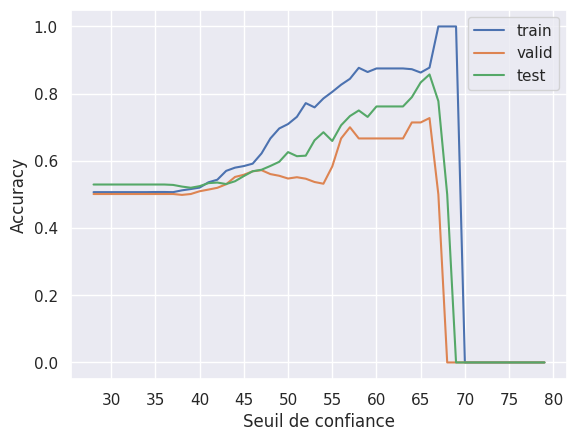

In [137]:
import matplotlib.pyplot as plt

# Votre code pour créer le graphique
fig, ax = plt.subplots()

# Tracer les courbes pour chaque colonne
for colonne in df.columns:
    ax.plot(df[colonne].index + 28, df[colonne], label=colonne)

# Ajouter une légende
ax.legend()

# Ajouter un titre à l'abscisse et à l'ordonnée
ax.set_xlabel('Seuil de confiance')
ax.set_ylabel('Accuracy')

# Augmenter la fréquence du cadrillage
ax.xaxis.set_ticks(range(min(df.index) + 28+2, max(df.index) + 28+2, 5))  # Par exemple, chaque 5 unités sur l'axe des x
# ax.yaxis.set_ticks(range(min(df.values.min()), max(df.values.max()) + 1, 5))  # Par exemple, chaque 5 unités sur l'axe des y

# Afficher le graphique
plt.show()

In [138]:
y_test.shape

(389,)

In [139]:
seuil_cut = 0.66 #

In [140]:
y_train_pred = modele.predict(X_train_scaled)
y_train_proba = modele.predict_proba(X_train_scaled)

df_train = pd.DataFrame({'y_train_pred': y_train_pred,
                   'y_train_proba_0': y_train_proba[:, 0],
                   'y_train_proba_1': y_train_proba[:, 1],
                   'y_train_proba_2': y_train_proba[:, 2],
                   'y_train_test': y_train})

df_train['confidence_percentage'] = np.max(y_train_proba, axis=1)

df_train = df_train[df_train['confidence_percentage']>seuil_cut]

print(pd.crosstab(df_train['y_train_test'], df_train['y_train_pred'], rownames=['Classe réelle'], colnames=['Classe prédite par XGBoost']))
score_train_filtered = accuracy_score(df_train['y_train_test'], df_train['y_train_pred'])
print(score_train_filtered)

Classe prédite par XGBoost   1
Classe réelle                 
0                            4
1                           43
2                            2
0.8775510204081632


In [141]:
y_valid_pred = modele.predict(X_valid_scaled)
y_valid_proba = modele.predict_proba(X_valid_scaled)

df_valid = pd.DataFrame({'y_valid_pred': y_valid_pred,
                   'y_valid_proba_0': y_valid_proba[:, 0],
                   'y_valid_proba_1': y_valid_proba[:, 1],
                   'y_valid_proba_2': y_valid_proba[:, 2],
                   'y_valid_test': y_valid})

df_valid['confidence_percentage'] = np.max(y_valid_proba, axis=1)

df_valid = df_valid[df_valid['confidence_percentage']>seuil_cut]

print(pd.crosstab(df_valid['y_valid_test'], df_valid['y_valid_pred'], rownames=['Classe réelle'], colnames=['Classe prédite par XGBoost']))
score_valid_filtered = accuracy_score(df_valid['y_valid_test'], df_valid['y_valid_pred'])
print(score_valid_filtered)



Classe prédite par XGBoost  1
Classe réelle                
0                           3
1                           8
0.7272727272727273


In [142]:
print(score_train_filtered - score_valid_filtered)

0.15027829313543595


In [143]:
X_test_scaled.tail(5)

,Season,elo_diff_cuted,diff_with_avg_a_m_cuted,diff_with_avg_h_m_cuted,diff_with_avg_a_d_cuted,diff_with_avg_h_d_cuted,diff_with_avg_a_f_cuted,diff_with_avg_h_f_cuted,diff_with_avg_a_g_cuted,diff_with_avg_h_g_cuted,FTAG,AS,AST,bkm_prediction,Elo_Home,Elo_Away,elo_diff,sum_win_last_5_Home,sum_win_last_3_Home,sum_lose_last_3_Home,tackles_h_f,dispossesed_h_m,pen_miss_h_m,pen_won_a_d,passes_a_d,passes_acc_a_d,keyPasses_a_d,score_pos_a_d,diff_with_avg_a_d,passes_acc_a_g,shots_on_goal_a_f,total_crosses_a_f,acc_crosses_a_f,passes_a_f,passes_acc_a_f,score_pos_a_f,score_pos_avg_grouped_date_h_or_a_and_pos_a_f,diff_with_avg_a_f,total_crosses_a_m,big_chance_created_a_m,passes_a_m,passes_acc_a_m,score_pos_a_m,diff_with_avg_a_m,HomeTeam_Ajaccio,HomeTeam_Ajaccio GFCO,HomeTeam_Amiens,HomeTeam_Angers,HomeTeam_Bastia,HomeTeam_Bordeaux,HomeTeam_Brest,HomeTeam_Caen,HomeTeam_Clermont,HomeTeam_Dijon,HomeTeam_Guingamp,HomeTeam_Le Havre,HomeTeam_Lens,HomeTeam_Lille,HomeTeam_Lorient,HomeTeam_Lyon,HomeTeam_Marseille,HomeTeam_Metz,HomeTeam_Monaco,HomeTeam_Montpellier,HomeTeam_Nancy,HomeTeam_Nantes,HomeTeam_Nice,HomeTeam_Nimes,HomeTeam_Paris SG,HomeTeam_Reims,HomeTeam_Rennes,HomeTeam_St Etienne,HomeTeam_Strasbourg,HomeTeam_Toulouse,HomeTeam_Troyes,AwayTeam_Ajaccio,AwayTeam_Ajaccio GFCO,AwayTeam_Amiens,AwayTeam_Angers,AwayTeam_Bastia,AwayTeam_Bordeaux,AwayTeam_Brest,AwayTeam_Caen,AwayTeam_Clermont,AwayTeam_Dijon,AwayTeam_Guingamp,AwayTeam_Le Havre,AwayTeam_Lens,AwayTeam_Lille,AwayTeam_Lorient,AwayTeam_Lyon,AwayTeam_Marseille,AwayTeam_Metz,AwayTeam_Monaco,AwayTeam_Montpellier,AwayTeam_Nancy,AwayTeam_Nantes,AwayTeam_Nice,AwayTeam_Nimes,AwayTeam_Paris SG,AwayTeam_Reims,AwayTeam_Rennes,AwayTeam_St Etienne,AwayTeam_Strasbourg,AwayTeam_Toulouse,AwayTeam_Troyes
384,1.6,0.866667,0.846154,0.400000,0.733333,0.357143,0.222222,0.615385,0.200000,0.000000,0.363636,0.379310,0.518519,0.0,0.634605,0.538071,0.576433,0.4,0.666667,0.333333,0.50,0.092593,0.0,0.0,0.837647,0.838091,0.2500,0.867764,0.738543,0.719192,0.117647,0.071429,0.083333,0.221354,0.234735,0.233500,0.460159,0.204904,0.435897,1.333333,0.787485,0.738101,0.760300,0.840862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,1.6,0.066667,0.615385,0.466667,0.933333,0.500000,1.111111,0.153846,0.466667,0.357143,0.090909,0.465517,0.185185,1.0,0.578728,0.773648,0.404540,0.2,0.333333,0.000000,0.30,0.222222,0.0,0.0,1.124706,1.152090,0.5000,1.142138,0.992284,0.665191,0.705882,0.571429,0.666667,1.020833,1.052061,1.148080,0.667397,1.124592,0.115385,0.666667,0.605667,0.607766,0.603949,0.615719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
386,1.6,0.200000,0.307692,0.333333,0.466667,0.357143,0.333333,0.076923,0.466667,0.214286,0.272727,0.396552,0.333333,0.0,0.389023,0.361636,0.537455,0.6,0.666667,0.000000,0.15,0.101852,0.0,0.0,0.582353,0.544028,0.2500,0.659240,0.514491,0.535587,0.117647,0.071429,0.083333,0.380208,0.320602,0.341400,0.538444,0.271668,0.282051,0.333333,0.402597,0.340948,0.349471,0.362464,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
387,1.6,0.600000,0.307692,0.200000,0.400000,0.285714,0.333333,0.230769,0.466667,0.571429,0.272727,0.362069,0.259259,0.0,0.540176,0.197824,0.722510,0.0,0.000000,0.666667,0.25,0.111111,0.0,0.0,0.541176,0.482973,0.3125,0.573880,0.404302,0.330381,0.176471,0.238095,0.250000,0.388021,0.361945,0.408195,0.584111,0.315165,0.166667,0.666667,0.325856,0.296684,0.311639,0.315878,0.0,0.0,0.0,0.0,0.0,0.0

In [144]:
y_test_pred = modele.predict(X_test_scaled)
y_test_proba = modele.predict_proba(X_test_scaled)

df_test = pd.DataFrame({'y_test_pred': y_test_pred,
                   'y_test_proba_0': y_test_proba[:, 0],
                   'y_test_proba_1': y_test_proba[:, 1],
                   'y_test_proba_2': y_test_proba[:, 2],
                   'y_test_test': y_test,
                   'index_origin' : y_test.index})

df_test['confidence_percentage'] = np.max(y_test_proba, axis=1)

max_proba_values = np.max(y_test_proba, axis=1)
df_test['y_test_proba_max'] = max_proba_values

df_test = df_test[(df_test['confidence_percentage']>seuil_cut)]
# df_test = df_test[df_test['confidence_percentage']>0.68]


print(pd.crosstab(df_test['y_test_test'], df_test['y_test_pred'], rownames=['Classe réelle'], colnames=['Classe prédite par XGBoost']))
score_test_filtered = accuracy_score(df_test['y_test_test'], df_test['y_test_pred'])
print(score_test_filtered)

Classe prédite par XGBoost   1
Classe réelle                 
1                           12
2                            2
0.8571428571428571


In [145]:
base_cagnotte=0
mise = 50
mise_min=50
mise_max=200
surete=seuil_cut
cagnotte = base_cagnotte
mise_totale = 0

# cote_365 = cote #pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_main_stats_cotes_elo_5games_roula9nte.csv', encoding='utf-8', sep=",", parse_dates=['Date'])
# cote_365 = cote_365.sort_values(by=['Date']).reset_index(drop=True)
cote = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/cote_for_streamlit.csv', encoding='utf-8', sep=",", parse_dates=['Date'])
cote = cote[['B365H','B365A','B365D','HomeTeam','AwayTeam','Date','Season']] #.reset_index()
cote['index_origin'] = cote.index

df_test = pd.merge(df_test, cote, how="inner", left_on=['index_origin'], right_on=['index_origin'])

df_test["cote_gain"] = np.where(df_test['y_test_test'] == 0, df_test['B365D'],
                   np.where(df_test['y_test_test'] == 1, df_test['B365H'],
                            df_test['B365A']))

df_test["gain"] = np.where(df_test['y_test_test']==df_test['y_test_pred'], mise*df_test['cote_gain']-mise,(-1)*mise)
df_test["gain_2_0"] = np.where(df_test['y_test_test']==df_test['y_test_pred'],round((mise_min+(mise_max-mise_min)*(df_test['y_test_proba_max']-surete)/(1-surete))*(df_test['cote_gain']-1)),(-1)*round(mise_min+(mise_max-mise_min)*(df_test['y_test_proba_max']-surete)/(1-surete)))
df_test["montant_joue"] = round(mise_min+(mise_max-mise_min)*(df_test['y_test_proba_max']-surete)/(1-surete))
# df_test = df_test[df_test['Season']=='2023-2024']
df_test.sort_values(by=['Date']).tail(11)


,y_test_pred,y_test_proba_0,y_test_proba_1,y_test_proba_2,y_test_test,index_origin,confidence_percentage,y_test_proba_max,B365H,B365A,B365D,HomeTeam,AwayTeam,Date,Season,cote_gain,gain,gain_2_0,montant_joue
3,1,0.152825,0.673024,0.174151,1,1628,0.673024,0.673024,1.16,13.0,8.50,Paris SG,Nice,2022-10-01,2022-2023,1.16,8.0,9.0,56.0
4,1,0.141760,0.681753,0.176487,2,1635,0.681753,0.681753,1.33,10.0,4.75,Marseille,Ajaccio,2022-10-08,2022-2023,10.00,-50.0,-60.0,60.0
5,1,0.148805,0.672836,0.178359,1,1662,0.672836,0.672836,1.09,23.0,11.00,Paris SG,Troyes,2022-10-29,2022-2023,1.09,4.5,5.0,56.0
6,1,0.142994,0.679369,0.177636,1,1717,0.679369,0.679369,1.40,8.0,4.75,Monaco,Ajaccio,2023-01-15,2022-2023,1.40,20.0,23.0,59.0
7,1,0.167925,0.661028,0.171047,1,1771,0.661028,0.661028,1.30,10.0,5.50,Paris SG,Nantes,2023-03-04,2022-2023,1.30,15.0,15.0,50.0
8,1,0.144578,0.678114,0.177308,1,1790,0.678114,0.678114,1.25,11.0,6.00,Lens,Angers,2023-03-18,2022-2023,1.25,12.5,14.0,58.0
9,1,0.132355,0.660271,0.207373,1,1819,0.660271,0.660271,1.20,13.0,7.00,Marseille,Troyes,2023-04-16,2022-2023,1.20,10.0,10.0,50.0
10,1,0.157535,0.678197,0.164268,1,1831,0.678197,0.678197,1.22,15.0,6.00,Lille,Ajaccio,2023-04-29,2022-2023,1.22,11.0,13.0,58.0
11,1,0.152332,0.673416,0.174252,2,1834,0.673416,0.673416,1.18,12.0,8.00,Paris SG,Lorient,2023-04-30,2022-2023,12.00,-50.0,-56.0,56.0
12,1,0.139777,0.681920,0.178303,1,1836,0.681920,0.681920,1.29,11.0,5.50,Rennes,Angers,2023-04-30,2022-2023,1.29,14.5,17.0,60.0


In [146]:
df_test['gain'].sum()
# revoir les y_test et y_pred. Semble plus correspondre au vrai data entre debut et fin

31.999999999999993

In [147]:
df_test['gain'].count()

14

In [148]:
df_test['gain_2_0'].sum()

29.0

In [149]:
df_test['montant_joue'].sum()

777.0

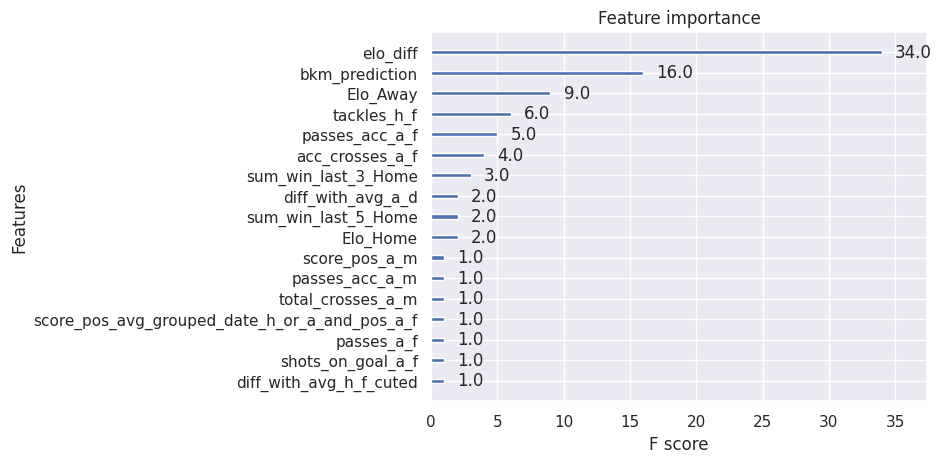

In [150]:
from xgboost import plotting
plotting.plot_importance(bst, max_num_features=30)
plt.show()

In [ ]:
df_test.shape

(31, 19)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

lr = LogisticRegression(random_state=7, max_iter=2000)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=7,n_estimators=50,max_depth=5)
xgb1 = xgb.XGBClassifier(max_depth=2, min_child_weight=5, n_estimators=25, random_state=7)

# Entraînement des modèles
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_valid_pred = lr.predict(X_valid_scaled)
y_test_pred = lr.predict(X_test_scaled)
print("Training Accuracy - lr: {:.2f}%".format(accuracy_score(y_train, y_train_pred)*100))
print("Valid Accuracy - lr: {:.2f}%".format(accuracy_score(y_valid, y_valid_pred)*100))
print("Test Accuracy - lr: {:.2f}%".format(accuracy_score(y_test, y_test_pred)*100))

knn.fit(X_train_scaled, y_train)
y_train_pred = knn.predict(X_train_scaled)
y_valid_pred = knn.predict(X_valid_scaled)
y_test_pred = knn.predict(X_test_scaled)
print("Training Accuracy - knn: {:.2f}%".format(accuracy_score(y_train, y_train_pred)*100))
print("Valid Accuracy - knn: {:.2f}%".format(accuracy_score(y_valid, y_valid_pred)*100))
print("Test Accuracy - knn: {:.2f}%".format(accuracy_score(y_test, y_test_pred)*100))

rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_valid_pred = rf.predict(X_valid_scaled)
y_test_pred = rf.predict(X_test_scaled)
print("Training Accuracy - rf: {:.2f}%".format(accuracy_score(y_train, y_train_pred)*100))
print("Valid Accuracy - rf: {:.2f}%".format(accuracy_score(y_valid, y_valid_pred)*100))
print("Test Accuracy - rf: {:.2f}%".format(accuracy_score(y_test, y_test_pred)*100))

xgb1.fit(X_train_scaled, y_train)
y_train_pred = xgb1.predict(X_train_scaled)
y_valid_pred = xgb1.predict(X_valid_scaled)
y_test_pred = xgb1.predict(X_test_scaled)
print("Training Accuracy - XGBoost: {:.2f}%".format(accuracy_score(y_train, y_train_pred)*100))
print("Valid Accuracy - XGBoost: {:.2f}%".format(accuracy_score(y_valid, y_valid_pred)*100))
print("Test Accuracy - XGBoost: {:.2f}%".format(accuracy_score(y_test, y_test_pred)*100))

Training Accuracy - lr: 59.20%
Valid Accuracy - lr: 43.70%
Test Accuracy - lr: 42.93%
Training Accuracy - knn: 65.04%
Valid Accuracy - knn: 36.25%
Test Accuracy - knn: 34.96%
Training Accuracy - rf: 64.90%
Valid Accuracy - rf: 47.04%
Test Accuracy - rf: 49.87%
Training Accuracy - XGBoost: 64.29%
Valid Accuracy - XGBoost: 46.02%
Test Accuracy - XGBoost: 50.13%


In [ ]:
print(pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite par XGBoost']))
print(classification_report(y_test, y_test_pred))

Classe prédite par XGBoost   0   1   2
Classe réelle                         
0                           22  30  49
1                           32  86  41
2                           22  20  87
              precision    recall  f1-score   support

           0       0.29      0.22      0.25       101
           1       0.63      0.54      0.58       159
           2       0.49      0.67      0.57       129

    accuracy                           0.50       389
   macro avg       0.47      0.48      0.47       389
weighted avg       0.50      0.50      0.49       389



In [ ]:
# code en plus

In [ ]:
df_2024_joueurs = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/stats_joueurs_2024.csv', encoding='utf-8', sep=",", parse_dates=['date'], dayfirst=True)])

In [ ]:
df_local = df_2024_joueurs[df_2024_joueurs['local_player_name'].notna()].copy()
df_local = df_local.drop(['visitor_player_acc_crosses',
 'visitor_player_aerials_won',
 'visitor_player_assists',
 'visitor_player_big_chance_created',
 'visitor_player_big_chance_missed',
 'visitor_player_blocks',
 'visitor_player_clearance_offine',
 'visitor_player_clearances',
 'visitor_player_dispossesed',
 'visitor_player_dribbleAttempts',
 'visitor_player_dribbledPast',
 'visitor_player_dribbleSucc',
 'visitor_player_duelsTotal',
 'visitor_player_duelsWon',
 'visitor_player_error_lead_to_goal',
 'visitor_player_fouls_commited',
 'visitor_player_fouls_drawn',
 'visitor_player_goals',
 'visitor_player_goals_conceded',
 'visitor_player_good_high_claim',
 'visitor_player_hit_woodwork',
 'visitor_player_id',
 'visitor_player_interceptions',
 'visitor_player_isCaptain',
 'visitor_player_isSubst',
 'visitor_player_keyPasses',
 'visitor_player_lastman_tackle',
 'visitor_player_minus_goals',
 'visitor_player_minutes_played',
 'visitor_player_name',
 'visitor_player_num',
 'visitor_player_offsides',
 'visitor_player_passes',
 'visitor_player_passes_acc',
 'visitor_player_pen_committed',
 'visitor_player_pen_miss',
 'visitor_player_pen_save',
 'visitor_player_pen_score',
 'visitor_player_pen_won',
 'visitor_player_pos',
 'visitor_player_punches',
 'visitor_player_rating',
 'visitor_player_redcards',
 'visitor_player_saves',
 'visitor_player_savesInsideBox',
 'visitor_player_shots_on_goal',
 'visitor_player_shots_total',
 'visitor_player_tackles',
 'visitor_player_total_crosses',
 'visitor_player_yellowcards',
 'match_id',
 'localteam_id',
 'visitorteam_id'], axis=1)

nouveaux_noms = {
'date':'Date',
'localteam_name':'localteam.name',
'localteam_score':'localteam.goals',
'visitorteam_name':'visitorteam.name',
'visitorteam_score':'visitorteam.goals',
'local_player_acc_crosses':'acc_crosses',
'local_player_aerials_won':'aerials_won',
'local_player_assists':'assists',
'local_player_big_chance_created':'big_chance_created',
'local_player_big_chance_missed':'big_chance_missed',
'local_player_blocks':'blocks',
'local_player_clearance_offine':'clearance_offine',
'local_player_clearances':'clearances',
'local_player_dispossesed':'dispossesed',
'local_player_dribbleAttempts':'dribbleAttempts',
'local_player_dribbledPast':'dribbledPast',
'local_player_dribbleSucc':'dribbleSucc',
'local_player_duelsTotal':'duelsTotal',
'local_player_duelsWon':'duelsWon',
'local_player_error_lead_to_goal':'error_lead_to_goal',
'local_player_fouls_commited':'fouls_commited',
'local_player_fouls_drawn':'fouls_drawn',
'local_player_goals':'goals',
'local_player_goals_conceded':'goals_conceded',
'local_player_good_high_claim':'good_high_claim',
'local_player_hit_woodwork':'hit_woodwork',
'local_player_id':'id',
'local_player_interceptions':'interceptions',
'local_player_isCaptain':'isCaptain',
'local_player_isSubst':'isSubst',
'local_player_keyPasses':'keyPasses',
'local_player_lastman_tackle':'lastman_tackle',
'local_player_minus_goals':'minus_goals',
'local_player_minutes_played':'minutes_played',
'local_player_name':'name',
'local_player_num':'num',
'local_player_offsides':'offsides',
'local_player_passes':'passes',
'local_player_passes_acc':'passes_acc',
'local_player_pen_committed':'pen_committed',
'local_player_pen_miss':'pen_miss',
'local_player_pen_save':'pen_save',
'local_player_pen_score':'pen_score',
'local_player_pen_won':'pen_won',
'local_player_pos':'pos',
'local_player_punches':'punches',
'local_player_rating':'rating',
'local_player_redcards':'redcards',
'local_player_saves':'saves',
'local_player_savesInsideBox':'savesInsideBox',
'local_player_shots_on_goal':'shots_on_goal',
'local_player_shots_total':'shots_total',
'local_player_tackles':'tackles',
'local_player_total_crosses':'total_crosses',
'local_player_yellowcards':'yellowcards'}
df_local.rename(columns=nouveaux_noms, inplace=True)

df_local['team'] = 'localteam'

df_local.head(3)

,Date,localteam.name,localteam.goals,visitorteam.name,visitorteam.goals,acc_crosses,aerials_won,assists,big_chance_created,big_chance_missed,blocks,clearance_offine,clearances,dispossesed,dribbleAttempts,dribbledPast,dribbleSucc,duelsTotal,duelsWon,error_lead_to_goal,fouls_commited,fouls_drawn,goals,goals_conceded,good_high_claim,hit_woodwork,id,interceptions,isCaptain,isSubst,keyPasses,lastman_tackle,minus_goals,minutes_played,name,num,offsides,passes,passes_acc,pen_committed,pen_miss,pen_save,pen_score,pen_won,pos,punches,rating,redcards,saves,savesInsideBox,shots_on_goal,shots_total,tackles,total_crosses,yellowcards,team
0,2024-02-25,Lens,2,Monaco,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,3.0,1.0,NaN,191560.0,NaN,True,False,NaN,NaN,3.0,90.0,Brice Samba,30.0,NaN,45.0,38.0,1.0,0.0,1.0,0.0,NaN,G,NaN,7.5,0.0,6.0,6.0,NaN,NaN,NaN,NaN,1.0,localteam
1,2024-02-25,Lens,2,Monaco,3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,204779.0,1.0,NaN,False,NaN,NaN,2.0,45.0,Jonathan Gradit,24.0,NaN,29.0,27.0,NaN,0.0,NaN,0.0,NaN,D,NaN,6.5,0.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,localteam
2,2024-02-25,Lens,2,Monaco,3,NaN,1.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,2.0,NaN,7.0,2.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,396792.0,1.0,NaN,False,NaN,NaN,3.0,90.0,Kevin Danso,4.0,NaN,72.0,57.0,NaN,0.0,NaN,0.0,NaN,D,NaN,6.3,0.0,NaN,NaN,NaN,1.0,NaN,NaN,0.0,localteam


In [ ]:
df_visitor = df_2024_joueurs[df_2024_joueurs['visitor_player_name'].notna()].copy()
df_visitor = df_visitor.drop(['local_player_acc_crosses',
 'local_player_aerials_won',
 'local_player_assists',
 'local_player_big_chance_created',
 'local_player_big_chance_missed',
 'local_player_blocks',
 'local_player_clearance_offine',
 'local_player_clearances',
 'local_player_dispossesed',
 'local_player_dribbleAttempts',
 'local_player_dribbledPast',
 'local_player_dribbleSucc',
 'local_player_duelsTotal',
 'local_player_duelsWon',
 'local_player_error_lead_to_goal',
 'local_player_fouls_commited',
 'local_player_fouls_drawn',
 'local_player_goals',
 'local_player_goals_conceded',
 'local_player_good_high_claim',
 'local_player_hit_woodwork',
 'local_player_id',
 'local_player_interceptions',
 'local_player_isCaptain',
 'local_player_isSubst',
 'local_player_keyPasses',
 'local_player_lastman_tackle',
 'local_player_minus_goals',
 'local_player_minutes_played',
 'local_player_name',
 'local_player_num',
 'local_player_offsides',
 'local_player_passes',
 'local_player_passes_acc',
 'local_player_pen_committed',
 'local_player_pen_miss',
 'local_player_pen_save',
 'local_player_pen_score',
 'local_player_pen_won',
 'local_player_pos',
 'local_player_punches',
 'local_player_rating',
 'local_player_redcards',
 'local_player_saves',
 'local_player_savesInsideBox',
 'local_player_shots_on_goal',
 'local_player_shots_total',
 'local_player_tackles',
 'local_player_total_crosses',
 'local_player_yellowcards',
 'match_id',
 'localteam_id',
 'visitorteam_id'], axis=1)

nouveaux_noms = {
'date':'Date',
'localteam_name':'localteam.name',
'localteam_score':'localteam.goals',
'visitorteam_name':'visitorteam.name',
'visitorteam_score':'visitorteam.goals',
'visitor_player_acc_crosses':'acc_crosses',
'visitor_player_aerials_won':'aerials_won',
'visitor_player_assists':'assists',
'visitor_player_big_chance_created':'big_chance_created',
'visitor_player_big_chance_missed':'big_chance_missed',
'visitor_player_blocks':'blocks',
'visitor_player_clearance_offine':'clearance_offine',
'visitor_player_clearances':'clearances',
'visitor_player_dispossesed':'dispossesed',
'visitor_player_dribbleAttempts':'dribbleAttempts',
'visitor_player_dribbledPast':'dribbledPast',
'visitor_player_dribbleSucc':'dribbleSucc',
'visitor_player_duelsTotal':'duelsTotal',
'visitor_player_duelsWon':'duelsWon',
'visitor_player_error_lead_to_goal':'error_lead_to_goal',
'visitor_player_fouls_commited':'fouls_commited',
'visitor_player_fouls_drawn':'fouls_drawn',
'visitor_player_goals':'goals',
'visitor_player_goals_conceded':'goals_conceded',
'visitor_player_good_high_claim':'good_high_claim',
'visitor_player_hit_woodwork':'hit_woodwork',
'visitor_player_id':'id',
'visitor_player_interceptions':'interceptions',
'visitor_player_isCaptain':'isCaptain',
'visitor_player_isSubst':'isSubst',
'visitor_player_keyPasses':'keyPasses',
'visitor_player_lastman_tackle':'lastman_tackle',
'visitor_player_minus_goals':'minus_goals',
'visitor_player_minutes_played':'minutes_played',
'visitor_player_name':'name',
'visitor_player_num':'num',
'visitor_player_offsides':'offsides',
'visitor_player_passes':'passes',
'visitor_player_passes_acc':'passes_acc',
'visitor_player_pen_committed':'pen_committed',
'visitor_player_pen_miss':'pen_miss',
'visitor_player_pen_save':'pen_save',
'visitor_player_pen_score':'pen_score',
'visitor_player_pen_won':'pen_won',
'visitor_player_pos':'pos',
'visitor_player_punches':'punches',
'visitor_player_rating':'rating',
'visitor_player_redcards':'redcards',
'visitor_player_saves':'saves',
'visitor_player_savesInsideBox':'savesInsideBox',
'visitor_player_shots_on_goal':'shots_on_goal',
'visitor_player_shots_total':'shots_total',
'visitor_player_tackles':'tackles',
'visitor_player_total_crosses':'total_crosses',
'visitor_player_yellowcards':'yellowcards'}
df_visitor.rename(columns=nouveaux_noms, inplace=True)

df_visitor['team'] = 'visitorteam'

df_visitor.head(3)

,Date,localteam.name,localteam.goals,visitorteam.name,visitorteam.goals,acc_crosses,aerials_won,assists,big_chance_created,big_chance_missed,blocks,clearance_offine,clearances,dispossesed,dribbleAttempts,dribbledPast,dribbleSucc,duelsTotal,duelsWon,error_lead_to_goal,fouls_commited,fouls_drawn,goals,goals_conceded,good_high_claim,hit_woodwork,id,interceptions,isCaptain,isSubst,keyPasses,lastman_tackle,minus_goals,minutes_played,name,num,offsides,passes,passes_acc,pen_committed,pen_miss,pen_save,pen_score,pen_won,pos,punches,rating,redcards,saves,savesInsideBox,shots_on_goal,shots_total,tackles,total_crosses,yellowcards,team
20,2024-02-25,Lens,2,Monaco,3,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,423915.0,NaN,NaN,False,NaN,NaN,2.0,90.0,Radosław Majecki,1.0,NaN,28.0,16.0,NaN,0.0,0.0,0.0,NaN,G,NaN,8.5,0.0,8.0,5.0,NaN,NaN,NaN,NaN,1.0,visitorteam
21,2024-02-25,Lens,2,Monaco,3,NaN,2.0,1.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0,2.0,1.0,12.0,6.0,NaN,3.0,2.0,NaN,0.0,NaN,NaN,598633.0,4.0,NaN,False,1.0,NaN,2.0,90.0,Wilfried Singo,99.0,NaN,48.0,41.0,NaN,0.0,NaN,0.0,NaN,D,NaN,7.3,0.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,visitorteam
22,2024-02-25,Lens,2,Monaco,3,NaN,2.0,NaN,NaN,NaN,2.0,NaN,7.0,NaN,NaN,NaN,NaN,7.0,6.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN,248739.0,NaN,NaN,False,NaN,NaN,2.0,90.0,Guillermo Maripán,3.0,NaN,36.0,32.0,NaN,0.0,NaN,0.0,NaN,D,NaN,7.0,0.0,NaN,NaN,NaN,NaN,2.0,NaN,0.0,visitorteam


In [ ]:
df_global = pd.concat([df_local, df_visitor])
df_global['season']='2023/2024'
df_global['leagueName']='France: Ligue 1'
df_global['note_globale']=np.nan
df_global['overall_score']=np.nan
df_global = df_global[['team','season','leagueName','localteam.name','visitorteam.name','localteam.goals','visitorteam.goals','num','name','pos','isCaptain','isSubst','shots_total','shots_on_goal',
                       'goals','goals_conceded','minus_goals','assists','offsides','fouls_drawn','fouls_commited','tackles','blocks','total_crosses','acc_crosses','interceptions','clearances',
                       'dispossesed','saves','punches','savesInsideBox','duelsTotal','duelsWon','aerials_won','dribbleAttempts','dribbleSucc','dribbledPast','yellowcards','big_chance_created',
                       'big_chance_missed','good_high_claim','clearance_offine','error_lead_to_goal','lastman_tackle','redcards','pen_score','pen_miss','pen_save','pen_committed','pen_won',
                       'hit_woodwork','passes','passes_acc','keyPasses','minutes_played','rating','id','note_globale','overall_score','Date']]
df_global.head(5)

,team,season,leagueName,localteam.name,visitorteam.name,localteam.goals,visitorteam.goals,num,name,pos,isCaptain,isSubst,shots_total,shots_on_goal,goals,goals_conceded,minus_goals,assists,offsides,fouls_drawn,fouls_commited,tackles,blocks,total_crosses,acc_crosses,interceptions,clearances,dispossesed,saves,punches,savesInsideBox,duelsTotal,duelsWon,aerials_won,dribbleAttempts,dribbleSucc,dribbledPast,yellowcards,big_chance_created,big_chance_missed,good_high_claim,clearance_offine,error_lead_to_goal,lastman_tackle,redcards,pen_score,pen_miss,pen_save,pen_committed,pen_won,hit_woodwork,passes,passes_acc,keyPasses,minutes_played,rating,id,note_globale,overall_score,Date
0,localteam,2023/2024,France: Ligue 1,Lens,Monaco,2,3,30.0,Brice Samba,G,True,False,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,NaN,NaN,45.0,38.0,NaN,90.0,7.5,191560.0,NaN,NaN,2024-02-25
1,localteam,2023/2024,France: Ligue 1,Lens,Monaco,2,3,24.0,Jonathan Gradit,D,NaN,False,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,29.0,27.0,NaN,45.0,6.5,204779.0,NaN,NaN,2024-02-25
2,localteam,2023/2024,France: Ligue 1,Lens,Monaco,2,3,4.0,Kevin Danso,D,NaN,False,1.0,NaN,NaN,0.0,3.0,NaN,NaN,1.0,1.0,NaN,2.0,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,7.0,2.0,1.0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,72.0,57.0,NaN,90.0,6.3,396792.0,NaN,NaN,2024-02-25
3,localteam,2023/2024,France: Ligue 1,Lens,Monaco,2,3,14.0,Facundo Medina,D,NaN,False,1.0,1.0,NaN,0.0,3.0,NaN,NaN,NaN,2.0,4.0,NaN,2.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,10.0,7.0,NaN,3.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,57.0,51.0,1.0,90.0,7.0,469493.0,NaN,NaN,2024-02-25
4,localteam,2023/2024,France: Ligue 1,Lens,Monaco,2,3,2.0,Ruben Aguilar,M,NaN,False,1.0,NaN,NaN,0.0,3.0,NaN,NaN,1.0,NaN,5.0,NaN,3.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,11.0,8.0,2.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,61.0,47.0,1.0,90.0,6.9,204771.0,NaN,NaN,2024-02-25


In [ ]:
df_global.shape

(239, 60)

In [ ]:
remplacements = {'GFC Ajaccio': 'Ajaccio GFCO', 'Saint-Etienne': 'St Etienne', 'AS Monaco':'Monaco'}
df_global["localteam.name"] = df_global["localteam.name"].replace(remplacements)
df_global["visitorteam.name"] = df_global["visitorteam.name"].replace(remplacements)
df_global = df_global[df_global["pos"]!="SUB"] # il n'y a que 3 lignes dans les data L1
df_global['Date'] = df_global.apply(lambda row: consolidate_date(row['season'], row['Date']), axis=1)
df_global["minutes_played"] = df_global["minutes_played"].apply(lambda x: int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 0)
df_global = df_global[df_global['minutes_played']>0]
df_global["rating"] = df_global["rating"].apply(lambda x: float(re.search(r'\d+\.\d+', str(x)).group()) if re.search(r'\d+\.\d+', str(x)) else 0)

In [ ]:
df_global_grouped = df_global.copy()
df_global_grouped['pos'].replace({'SUB_G': 'G', 'SUB_D': 'D', 'SUB_M': 'M', 'SUB_F':'F'}, inplace=True)
df_global_grouped = df_global_grouped[(df_global_grouped['pos']=='G')|(df_global_grouped['pos']=='D')|(df_global_grouped['pos']=='M')|(df_global_grouped['pos']=='F')]

In [ ]:
# Calcul de la médiane par groupe dans 'rating' quand minutes_played est en dessous de 8min
median_by_group = df_global_grouped[df_global_grouped['minutes_played']>8].groupby(['leagueName','Date','team','localteam.name','visitorteam.name','pos'])['rating'].median()
for (group_leagueName,group_Date,group_team,group_localteam,group_visitorteam,group_pos), median_value in median_by_group.items():
    df_global_grouped.loc[(df_global_grouped['rating'] == 0) & (df_global_grouped['minutes_played'] > 0) & (df_global_grouped['minutes_played'] <= 8) &
     (df_global_grouped['leagueName'] == group_leagueName) &
     (df_global_grouped['Date'] == group_Date) &
     (df_global_grouped['team'] == group_team) &
     (df_global_grouped['localteam.name'] == group_localteam) &
     (df_global_grouped['visitorteam.name'] == group_visitorteam) &
     (df_global_grouped['pos'] == group_pos), 'rating'] = median_value
df_global_grouped = df_global_grouped.reset_index(drop=True)

In [ ]:
df_global.shape

(183, 60)

In [ ]:
df_global_grouped.groupby(['localteam.name','visitorteam.name']).count()

,,team,season,leagueName,localteam.goals,visitorteam.goals,num,name,pos,isCaptain,isSubst,shots_total,shots_on_goal,goals,goals_conceded,minus_goals,assists,offsides,fouls_drawn,fouls_commited,tackles,blocks,total_crosses,acc_crosses,interceptions,clearances,dispossesed,saves,punches,savesInsideBox,duelsTotal,duelsWon,aerials_won,dribbleAttempts,dribbleSucc,dribbledPast,yellowcards,big_chance_created,big_chance_missed,good_high_claim,clearance_offine,error_lead_to_goal,lastman_tackle,redcards,pen_score,pen_miss,pen_save,pen_committed,pen_won,hit_woodwork,passes,passes_acc,keyPasses,minutes_played,rating,id,note_globale,overall_score,Date
localteam.name,visitorteam.name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Le Havre,Reims,28,28,28,28,28,28,28,28,2,28,13,7,2,28,28,0,2,14,16,17,10,13,7,10,16,8,2,0,2,26,23,11,13,8,10,28,3,2,0,0,0,0,28,28,28,2,2,2,1,28,28,9,28,28,28,0,0,28
Lens,Monaco,30,30,30,30,30,30,30,30,2,30,14,9,4,30,30,2,3,15,17,17,5,11,5,15,14,15,2,0,2,28,25,15,16,13,11,30,4,5,1,0,0,0,30,30,30,2,1,1,1,28,28,15,30,30,30,0,0,30
Marseille,Montpellier,32,32,32,32,32,32,32,32,2,32,11,6,3,32,32,2,0,11,11,19,4,13,5,10,18,11,2,1,2,28,24,7,17,12,15,32,4,2,1,0,1,0,32,32,32,2,1,1,2,32,31,13,32,32,32,0,0,32
Nice,Clermont Foot,32,32,32,32,32,32,32,32,2,32,15,7,0,32,32,0,1,14,14,20,7,15,8,10,15,8,2,0,2,27,24,17,15,9,9,32,3,5,1,0,0,1,32,32,32,2,1,1,0,32,31,16,32,32,32,0,0,32
Paris S.G.,Rennes,31,31,31,31,31,31,31,31,2,31,9,4,2,31,31,1,2,16,19,21,2,8,1,17,11,13,1,2,1,30,28,14,19,13,13,31,2,2,0,0,0,0,31,31,31,2,1,1,0,31,30,10,31,31,31,0,0,31
Toulouse,Lille,30,30,30,30,30,30,30,30,2,30,13,6,4,30,30,3,1,15,19,16,8,11,6,10,15,11,2,0,2,26,26,13,14,10,11,30,1,0,0,0,0,0,30,30,30,2,1,1,1,30,29,13,30,30,30,0,0,30


In [ ]:
df_global.to_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_joueurs_raw_first_clean_2024.csv', index=False)

In [ ]:
import os
path = "/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_all_season_raw_files/"
all_files=os.listdir(path)

In [ ]:
all_files

[]

In [ ]:
nouvel_ordre_colonnes = ["Div","Date","HomeTeam","AwayTeam","FTR","HTR",
                         "FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR","B365H","B365D","B365A","BWH","BWD","BWA","IWH","IWD","IWA","WHH","WHD","WHA","VCH","VCD","VCA"
                        ]

In [ ]:
result_df = result_df[nouvel_ordre_colonnes]
result_df.head(50)

,Div,Date,HomeTeam,AwayTeam,FTR,HTR,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,WHH,WHD,WHA,VCH,VCD,VCA
0,F1,11/08/2023,Nice,Lille,D,H,1.0,1.0,1.0,0.0,8.0,12.0,3.0,5.0,13.0,9.0,3.0,3.0,3.0,2.0,0.0,0.0,2.60,3.50,2.70,2.60,3.40,2.65,2.55,3.40,2.75,2.38,3.10,2.60,2.55,3.30,2.75
1,F1,12/08/2023,Marseille,Reims,H,D,2.0,1.0,1.0,1.0,14.0,11.0,4.0,4.0,7.0,16.0,10.0,10.0,1.0,3.0,0.0,0.0,1.70,4.00,4.75,1.65,4.10,4.80,1.70,3.95,4.80,1.60,3.60,4.50,1.67,3.80,5.00
2,F1,12/08/2023,Paris SG,Lorient,D,D,0.0,0.0,0.0,0.0,20.0,4.0,4.0,0.0,8.0,6.0,9.0,2.0,0.0,0.0,0.0,0.0,1.33,5.50,7.50,1.32,5.50,9.00,1.37,5.50,7.50,1.25,5.00,7.50,1.30,5.50,9.50
3,F1,13/08/2023,Brest,Lens,H,A,3.0,2.0,1.0,2.0,15.0,10.0,8.0,2.0,13.0,15.0,6.0,8.0,2.0,3.0,0.0,1.0,4.00,3.50,1.91,3.90,3.50,1.93,3.90,3.50,1.95,3.40,3.25,1.91,3.80,3.30,1.90
4,F1,13/08/2023,Clermont,Monaco,A,A,2.0,4.0,1.0,2.0,15.0,14.0,7.0,8.0,7.0,16.0,6.0,2.0,0.0,4.0,0.0,0.0,3.60,3.60,2.00,3.50,3.70,2.00,3.40,3.60,2.10,3.10,3.30,2.00,3.40,3.40,2.00
5,F1,13/08/2023,Montpellier,Le Havre,D,A,2.0,2.0,0.0,1.0,15.0,12.0,5.0,4.0,8.0,12.0,5.0,2.0,1.0,2.0,0.0,0.0,1.91,3.60,4.00,1.88,3.50,4.20,1.90,3.55,4.20,1.80,3.20,3.90,1.87,3.25,4.00
6,F1,13/08/2023,Nantes,Toulouse,A,H,1.0,2.0,1.0,0.0,9.0,9.0,4.0,5.0,14.0,14.0,7.0,5.0,2.0,2.0,0.0,0.0,2.50,3.40,2.75,2.50,3.40,2.75,2.60,3.40,2.70,2.30,3.10,2.70,2.55,3.20,2.63
7,F1,13/08/2023,Rennes,Metz,H,D,5.0,1.0,1.0,1.0,29.0,9.0,14.0,3.0,7.0,10.0,5.0,4.0,0.0,2.0,0.0,0.0,1.40,4.75,7.50,1.41,4.75,7.50,1.43,4.70,7.00,1.36,4.20,6.50,1.36,4.40,7.50
8,F1,13/08/2023,Strasbourg,Lyon,H,D,2.0,1.0,0.0,0.0,8.0,23.0,2.0,7.0,8.0,11.0,1.0,6.0,2.0,2.0,0.0,0.0,2.55,3.60,2.55,2.60,3.60,2.50,2.60,3.60,2.60,2.60,3.30,2.30,2.50,3.40,2.55
9,F1,18/08/2023,Metz,Marseille,D,A,2.0,2.0,0.0,1.0,10.0,22.0,5.0,5.0,15.0,9.0,4.0,9.0,3.0,2.0,1.0,0.0,5.00,4.00,1.67,4.75,3.90,1.70,4.60,3.85,1.73,4.00,3.60,1.67,4.80,3.90,1.67


In [ ]:

L1_main_stats_cotes = pd.concat([pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projet DATASCIENTEST/Rendu/Code/data_tests_2024/L1_all_seasons_raw.csv', encoding='utf-8', sep=",", parse_dates=['Date'], dayfirst=True)])
L1_main_stats_cotes['Date'] = pd.to_datetime(L1_main_stats_cotes['Date'], format='mixed', dayfirst=True)